## The Smoluchowski Problem Script

In [1]:
import matplotlib.pyplot as plt
import importlib
%matplotlib inline
if importlib.util.find_spec("matplotlib_inline") is not None:
    import matplotlib_inline
    matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
else:
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats('retina')

plt.ioff();

In [ ]:
# This cell is a sorry attempt at integrating the code onto google colab.
# Feel free to remove this cell if you are not using google colab.

import os, sys, sysconfig
from importlib.util import find_spec
is_colab = 'google.colab' in sys.modules
site_userpkg = sysconfig.get_paths()['purelib']
req_pkgscolab = ['tensorboardX', 'pyinstrument']
if is_colab and any(find_spec(pkg) is None for pkg in req_pkgscolab):
    ! pip install {" ".join(req_pkgscolab)}
if is_colab and not os.path.exists('/content/btspinn/'):
    ! cd /content && git clone https://github.com/ehsansaleh/btspinn.git
    ! cd /content/btspinn && pip install -e . && rm -rf *.egg-info
if is_colab and (find_spec('bspinn') is None):
    ! ln -s /content/btspinn/bspinn {site_userpkg}/bspinn
elif is_colab:
    ! [ -L {site_userpkg}/bspinn ] && rm {site_userpkg}/bspinn
if is_colab and os.path.exists('/content/btspinn/notebook'):
    os.chdir('/content/btspinn/notebook')

In [2]:
import numpy as np
import torch
import json
import yaml
import time
import shutil
import socket
import random
import psutil
import pathlib
import fnmatch
import datetime
import resource
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch.distributions as tchd 
from torch import nn
import tensorboardX
from copy import deepcopy
from pyinstrument import Profiler
from os.path import exists, isdir
from collections import defaultdict
from collections import OrderedDict as odict
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
from bspinn.io_utils import DataWriter
from bspinn.io_utils import get_git_commit
from bspinn.io_utils import preproc_cfgdict
from bspinn.io_utils import hie2deep, deep2hie
from bspinn.io_utils import get_arr, eval_formula, chck_dstrargs

from bspinn.tch_utils import isscalar
from bspinn.tch_utils import EMA
from bspinn.tch_utils import BatchRNG
from bspinn.tch_utils import bffnn
from bspinn.tch_utils import profmem

from bspinn.io_cfg import configs_dir
from bspinn.io_cfg import results_dir
from bspinn.io_cfg import storage_dir

In [4]:
pgms_cntr = 0
be_verbose = False
def print_gpumem_stat(tch_device):
    global pgms_cntr
    if not(str(tch_device).startswith('cuda')) or not(be_verbose):
        return
    t = torch.cuda.get_device_properties(tch_device).total_memory
    r = torch.cuda.memory_reserved(tch_device) / 1.0e9
    a = torch.cuda.memory_allocated(tch_device) / 1.0e9
    f = r - a  # free inside reserved
    print(f'Checkpoint {pgms_cntr}: Free: {f:.1f} GB, Allocated: {a:.1f} GB')
    pgms_cntr += 1

## Finding the Exact Smolluchowski Sum

In [5]:
class SMSum:
    def __init__(self, dim, n_gpd, x_high, get_kernel):
        """
        Defines the exact Smolluchowski summation over a fixed grid

        Parameters
        ----------
        dim: (int) the dimensionality of the points
        
        n_gpd: (int) the number of grid points in each dim
        
        x_high: (torch.tensor) the high boundary in each dim
        
        get_kernel: (callable) a function that takes two tensors 
                with shape (n, dim) and returns a (dim,) tensor.
        
        """
        
        # n_g -> The total number of points in the d-dim grid
        n_g = n_gpd ** dim
        
        tch_device = x_high.device
        tch_dtype = x_high.dtype
        assert x_high.shape == (dim,)
        
        x_int_pd = torch.arange(1, n_gpd+1, device=tch_device, dtype=torch.int64)
        x_int = torch.cat([x_int_pd.repeat_interleave(n_gpd**(dim-i-1), dim=0).repeat(
            (n_gpd**i,)).reshape(n_g, 1) for i in range(dim)], dim=1)
        assert x_int.shape == (n_g, dim)

        x_flt = x_int * (x_high / n_gpd)
        assert x_flt.shape == (n_g, dim)
        
        x_flt_area = x_flt.prod(dim=-1)
        assert x_flt_area.shape == (n_g,)
        
        # integration element volume size dx = dx1 * dx2 * ... * dxd
        assert x_high.shape == (dim,)
        dx_vol = torch.prod(x_high / n_gpd).item()
        x_high_area = torch.prod(x_high).item()
        
        # Meshed vectors of x_flt
        x_fmsh1 = x_flt.repeat_interleave(n_g, dim=0).reshape(n_g*n_g, dim)
        assert x_fmsh1.shape == (n_g*n_g, dim)
        x_fmsh2 = x_flt.repeat((n_g,1)).reshape(n_g*n_g, dim)
        assert x_fmsh2.shape == (n_g*n_g, dim)

        # Getting the kernel in flat and square forms
        K_1d = get_kernel(x_fmsh1, x_fmsh2)
        assert K_1d.shape == (n_g*n_g, )
        K_2d = K_1d.reshape(n_g, n_g)
        assert K_2d.shape == (n_g, n_g)

        # One time calculations
        delta_int = x_int.reshape(n_g, 1, dim) - x_int.reshape(1, n_g, dim)
        assert delta_int.shape == (n_g, n_g, dim)

        ispos = (delta_int > 0).all(dim=-1)
        assert ispos.shape == (n_g, n_g)

        M_nz_idx1d = torch.nonzero(ispos.reshape(-1)).reshape(-1)
        assert M_nz_idx1d.ndim == 1

        iii = n_gpd ** torch.arange(dim-1, -1, -1, device=tch_device, dtype=torch.int64).reshape(1, dim)
        K_nz_rowid1d = ((delta_int[ispos, :] - 1) * iii).sum(dim=-1)
        K_nz_idx1d = K_nz_rowid1d * n_g + (M_nz_idx1d % n_g)

        M_nz1d = K_1d[K_nz_idx1d]
        
        # needed for __call__
        self.n_g = n_g
        self.K_2d = K_2d
        self.M_nz_idx1d = M_nz_idx1d
        self.K_nz_rowid1d = K_nz_rowid1d
        self.M_nz_colid1d = M_nz_idx1d % n_g
        self.M_nz1d = M_nz1d
        self.dx_vol = dx_vol
        self.x_flt_area = x_flt_area
        self.x_high_area = x_high_area
        self.tch_device = tch_device
        self.tch_dtype = tch_dtype
        
        # only needed for tests
        self.x_flt = x_flt
        # self.x_int = x_int
        # self.x_fmsh1 = x_fmsh1
        # self.x_fmsh2 = x_fmsh2
        # self.dim = dim
        # self.n_gpd = n_gpd
        
        # Printing the memory usage
        if be_verbose:
            self.print_mem_usage()
    
    def get_x(self):
        return self.x_flt
        
    def __call__(self, rho, summer='efficient'):
        n_g, K_2d, M_nz1d = self.n_g, self.K_2d, self.M_nz1d
        M_nz_idx1d = self.M_nz_idx1d
        K_nz_rowid1d = self.K_nz_rowid1d
        M_nz_colid1d = self.M_nz_colid1d
        dx_vol = self.dx_vol
        x_flt_area = self.x_flt_area
        x_high_area = self.x_high_area
        
        assert rho.shape == (n_g,)
        L_nz1d = rho[K_nz_rowid1d]
        Q_nz1d = rho[M_nz_colid1d]
        
        influx = self.get_influx(Q_nz1d, L_nz1d, M_nz1d, M_nz_idx1d, n_g, summer, do_sq=False)
        assert influx.shape == (n_g,)
        
        influxsq = self.get_influx(Q_nz1d, L_nz1d, M_nz1d, M_nz_idx1d, n_g, summer, do_sq=True)
        assert influxsq.shape == (n_g,)
        
        K2drho = (K_2d * rho.reshape(1, n_g))
        assert K2drho.shape == (n_g, n_g)
        
        outflux = K2drho.sum(dim=-1) * rho
        assert outflux.shape == (n_g,)
        
        outfluxsq = K2drho.square().sum(dim=-1) * rho.square()
        assert outfluxsq.shape == (n_g,)
        
        # Accounting for dx in the Riemannian integration sum
        influx = influx * dx_vol
        outflux = outflux * dx_vol
        influxsq = influxsq * x_flt_area * dx_vol
        outfluxsq = outfluxsq * x_high_area * dx_vol
        
        outdict = dict(influx=influx, outflux=outflux,
                       influxsq=influxsq, outfluxsq=outfluxsq)
        
        # Running the test suite
        # assert summer == 'complete'
        # self.test_displacements(rho, Q, L, M)
        # self.test_conservation(influx, outflux)
        # self.test_smforloop(rho, influx, outflux)
        
        return outdict
    
    def get_influx(self, Q_nz1d, L_nz1d, M_nz1d, M_nz_idx1d, n_g, summer, do_sq=False):
        tch_device, tch_dtype = self.tch_device, self.tch_dtype 
        if summer == 'efficient':
            U_nz1d = (Q_nz1d * L_nz1d * M_nz1d)
            if do_sq:
                U_nz1d = U_nz1d.square()
            U_cs1d = torch.cumsum(U_nz1d, dim=0)
            ii = M_nz_idx1d // n_g
            jj = (ii < torch.cat([ii[1:], torch.full_like(ii[:1], n_g)], dim=0))
            kk = torch.nonzero(jj).reshape(-1)
            ll = ii[jj]
            vv = U_cs1d[kk]
            ww = vv - torch.cat([torch.zeros_like(vv[:1]), vv[:-1]], dim=0)
            influx = torch.zeros(n_g, device=tch_device, dtype=tch_dtype)
            influx[ll] = ww / (4. if do_sq else 2.)
            assert influx.shape == (n_g,)
        elif summer == 'complete':
            M_1d = torch.zeros(n_g*n_g, device=tch_device, dtype=tch_dtype)
            M_1d[M_nz_idx1d] = M_nz1d
            M = M_1d.reshape(n_g, n_g)
            L_1d = torch.zeros(n_g*n_g, device=tch_device, dtype=tch_dtype)
            L_1d[M_nz_idx1d] = L_nz1d
            L = L_1d.reshape(n_g, n_g)
            Q = rho.reshape(1,n_g).expand((n_g, n_g))
            QLM = (Q * L * M)
            if do_sq:
                QLM = QLM.square()
            influx = QLM.sum(dim=-1) / (4. if do_sq else 2.)
            assert influx.shape == (n_g,)
        else:
            raise ValueError(f'{influx_summer} not implemented!')
        
        return influx
    
    def test_displacements(self, rho, Q, L, M):
        """
        Making sure that for all i, j we have:
            M[i, j] = K[i-j, j],
            L[i, j] = rho[i-j],
            Q[i, j] = rho[j].
        """
        x_int, n_g, n_gpd, dim, K_2d = self.x_int, self.n_g, self.n_gpd, self.dim, self.K_2d

        x_imsh1 = x_int.repeat_interleave(n_g, dim=0).reshape(n_g*n_g, dim)
        assert x_imsh1.shape == (n_g*n_g, dim)
        x_imsh2 = x_int.repeat((n_g,1)).reshape(n_g*n_g, dim)
        assert x_imsh2.shape == (n_g*n_g, dim)
        xint2i = lambda xint: np.sum((xint - 1) * (n_gpd**(dim - 1 - np.arange(dim))))
        for xi_int, xj_int in zip(x_imsh1.detach().cpu().numpy(), x_imsh2.detach().cpu().numpy()):
            """Example: xi_int, xj_int = np.array([2, 3]), np.array([1, 2])"""
            if not (xi_int > xj_int).all():
                continue
            xij_int = xi_int - xj_int
            i = xint2i(xi_int)
            j = xint2i(xj_int)
            ij = xint2i(xij_int)
            assert torch.allclose(K_2d[ij, j], M[i,j])
            assert torch.allclose(L[i,j], rho[ij])
            assert torch.allclose(Q[i,j], rho[j])
            
    def test_conservation(self, influx, outflux):
        """
        Testing if the influx and outflux mass is being conserved or not.
        """
        x_int, n_g, dim = self.x_int, self.n_g, self.dim
        
        assert x_int.shape == (n_g, dim)
        mass_influx = (influx.reshape(n_g, 1)  * x_int).sum(dim=0)
        mass_outflux = (outflux.reshape(n_g, 1) * x_int).sum(dim=0)
        is_conserved = torch.allclose(mass_influx, mass_outflux)
        assert is_conserved, (f'Make sure the kernel does not allow ' + 
            f'coagulations beyond size {n_gpd} in each dimension')
    
    def test_smforloop(self, rho, influx, outflux):
        """
        Testing if the solving the SM equation with for loops yields the same results
        """
        x_int, n_gpd, dim, K_2d = self.x_int, self.n_gpd, self.dim, self.K_2d
        tch_device, tch_dtype = self.tch_device, self.tch_dtype
        
        xint2i = lambda xint: np.sum((xint - 1) * (n_gpd**(dim - 1 - np.arange(dim))))
        influx_for = []
        outflux_for = []
        for i, pnt_i in enumerate(x_int):
            i_inflx = 0.0
            i_otflx = 0.0
            for j, pnt_j in enumerate(x_int):
                assert pnt_i.shape == (dim,)
                assert pnt_j.shape == (dim,)

                i_otflx += (K_2d[i,j] * rho[i] * rho[j]).item()

                pnt_ij = pnt_i - pnt_j
                ij = xint2i(pnt_ij.detach().cpu().numpy())
                if not (pnt_ij > 0).all():
                    continue

                aa = K_2d[ij, j]
                bb = rho[ij]
                cc = rho[j]

                i_inflx += (aa*bb*cc).item()/2.
            influx_for.append(i_inflx)
            outflux_for.append(i_otflx)
        influx_for = torch.from_numpy(np.array(influx_for)).to(dtype=tch_dtype, device=tch_device)
        outflux_for = torch.from_numpy(np.array(outflux_for)).to(dtype=tch_dtype, device=tch_device)

        assert torch.allclose(influx_for, influx)
        assert torch.allclose(outflux_for, outflux)
    
    def print_mem_usage(self):
        total = 0
        print('SMSolver GPU Memory Usage:')
        for key, val in self.__dict__.items():
            if torch.is_tensor(val):
                valmem = val.element_size() * val.nelement() / 1.0e9
                total += valmem
                print(f'  {key}:{" " * (21-len(key))}{valmem:.3f} GB')
        print('  ' + '='*30)
        print(f'  Total:{16 * " "}{total:.3f} GB')

class CustomKernel:
    def __init__(self, pnorm, maxnorm, slope, alpha, beta, gamma):
        self.slope = slope
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.pnorm = pnorm
        self.maxnorm = maxnorm
        
    def __call__(self, x1, x2):
        """
        Defines the kernel function between two points.

        Parameters
        ----------
        x1     : torch.tensor with shape (..., n, d)
        x2     : torch.tensor with shape (..., n, d)

        Returns
        -------
        kvec   : torch.tensor with shape (n,)
        """
        pnorm, maxnorm, slope = self.pnorm, self.maxnorm, self.slope
        alpha, beta, gamma = self.alpha, self.beta, self.gamma
        
        n_tup, dim = x1.shape[:-1], x1.shape[-1]
        assert x1.shape == (*n_tup, dim)
        assert x2.shape == (*n_tup, dim)

        x12 = torch.cat([x1.unsqueeze(-1), x2.unsqueeze(-1)], dim=-1)
        assert x12.shape == (*n_tup, dim, 2)

        x12norm_d = torch.norm(x12, p=pnorm, dim=-1)
        assert x12norm_d.shape == (*n_tup, dim)

        x12norm = x12norm_d.sum(dim=-1)
        assert x12norm.shape == (*n_tup,)

        kvec = (x12norm.pow(alpha) + beta).abs().pow(gamma)
        assert kvec.shape == (*n_tup,)

        # Making sure no particles of size 1 or larger get created.
        kvec = kvec * (slope * (x12norm < maxnorm))
        assert kvec.shape == (*n_tup,)

        return kvec

class RhoGMM:
    def __init__(self, mix, loc, scale, bias, slope, t_ic=None):
        self.mix = tchd.Categorical(mix)
        self.comp = tchd.Normal(loc, scale)
        self.gmm = tchd.MixtureSameFamily(self.mix, self.comp)
        self.bias = bias
        self.slope = slope
        self.t_ic = t_ic
    
    def __call__(self, x, t=None):
        """
        Defines the initial masses using a GMM model.

        Parameters
        ----------
        x     : torch.tensor with shape (..., n, 1)

        Returns
        -------
        rho   : torch.tensor with shape (..., n)
        """
        assert (t is None) or (self.t_ic is None) or (t == self.t_ic).all()
        assert x.shape[-1] == 1, 'higher dim not implemented yet'
        n_tup, dim = x.shape[:-1], x.shape[-1]
        nrows = int(np.prod(n_tup))
        x_rshp = x.reshape(nrows, dim)
        rho = self.bias + self.gmm.log_prob(x_rshp).exp().reshape(*n_tup) * self.slope
        return rho

class RhoLin:
    def __init__(self, bias, slope, t_ic=None):
        assert torch.is_tensor(slope)
        assert slope.ndim == 1
        if torch.is_tensor(bias):
            assert bias.shape == tuple()
        else:
            assert isinstance(bias, (float, int))
        self.dim = slope.shape[-1]
        self.bias = bias
        self.slope = slope
        self.t_ic = t_ic
     
    def __call__(self, x, t=None):
        """
        Defines the initial masses using a negative-slope model.

        Parameters
        ----------
        x     : torch.tensor with shape (*n, d)

        Returns
        -------
        rho   : torch.tensor with shape (*n,)
        """
        assert (t is None) or (self.t_ic is None) or (t == self.t_ic).all()
        a = self.slope * x
        assert a.shape == x.shape
        rho = self.bias + a.sum(dim=-1)
        assert rho.shape == x.shape[:-1]
        return rho

### Some Tested Settings

In [6]:
ex_device_name = 'cuda:0'
ex_tch_device = torch.device(ex_device_name)
ex_tch_dtype = torch.double
be_verbose = True

In [7]:
"""
This setting has a moderate "variance to squared-mean" ratio for the time derivative:
   E_{xi}[Var_{xj}(d\rho/dt)] = 3.15
   E_{xi}[  E_{xj}[d\rho/dt]] = 1.05
   R = 3.15 / 1.05 = 3.01
"""

ex_dim = 1
ex_n_gpd = 200
ex_x_high = torch.tensor([1.0]*ex_dim, dtype=ex_tch_dtype, device=ex_tch_device)
ex_get_kernel = CustomKernel(pnorm=0.5, maxnorm=1.14, slope=1.23, 
                          alpha=1.5, beta=0.0, gamma=1.0)
ex_rho1, ex_rho2 = 3.0, 2.0
ex_islope = ex_x_high * ((ex_rho2 - ex_rho1) / ex_x_high.square().sum().item())
ex_get_rhoinit = RhoLin(bias=ex_rho1, slope=ex_islope)
ex_t_high = 1.0
ex_dt_g = ex_t_high / 100.0
ex_ker_name, ex_rhoi_name = 'harmonic_A', 'lin_A'

In [8]:
"""
The following was tested to produce issues for high-variance trainings.
We used w_tot, w_ic = 1.0, 1.0 was used in this trainings.
This setting has a low "variance to squared-mean" ratio for the time derivative:
   E_{xi}[Var_{xj}(d\rho/dt)] = 4.39
   E_{xi}[  E_{xj}[d\rho/dt]] = 201.59
   R = 4.39 / 201.59 = 0.02
That being said, since the initial condition loss has a low weight, the 
time-derivative variance prohibited the model from settling on the right 
initial condition. This resulted in a training with a wrong heatmap trend.
"""

ex_dim = 1
ex_n_gpd = 100
ex_x_high = torch.tensor([0.3]*ex_dim, dtype=ex_tch_dtype, device=ex_tch_device)
ex_get_kernel = CustomKernel(pnorm=1.0, maxnorm=1.0, slope=5.5, 
    alpha=-1.0, beta=-1.0, gamma=0.15)
ex_imix = torch.tensor([1.0], dtype=ex_tch_dtype, device=ex_tch_device)
ex_iloc = torch.tensor([0.0], dtype=ex_tch_dtype, device=ex_tch_device)
ex_iscale = torch.tensor([0.4], dtype=ex_tch_dtype, device=ex_tch_device)
ex_get_rhoinit = RhoGMM(mix=ex_imix, loc=ex_iloc, scale=ex_iscale, bias=1.5, slope=2.0)
ex_t_high = 0.03
ex_dt_g = ex_t_high / 100.0

In [9]:
"""
This setting has a long x tail with zero kernel and thus no time derivates.
The long kernel-less tak makes R high, since uniform sampling of j for the 
outflux calculation generates lots of zero values.
   E_{xi}[Var_{xj}(d\rho/dt)] = 3.6
   E_{xi}[  E_{xj}[d\rho/dt]] = 0.5
   -> R = 6.91
"""

ex_dim = 1
ex_n_gpd = 200
ex_x_high = torch.tensor([1.0]*ex_dim, dtype=ex_tch_dtype, device=ex_tch_device)
ex_get_kernel = CustomKernel(pnorm=.5, maxnorm=0.5, slope=5.0, 
    alpha=-5.0, beta=-0.33, gamma=-0.15)
ex_rho1, ex_rho2 = 3.0, 2.0
ex_islope = ex_x_high * ((ex_rho2 - ex_rho1) / ex_x_high.square().sum().item())
ex_get_rhoinit = RhoLin(bias=ex_rho1, slope=ex_islope)
ex_t_high = 1.0
ex_dt_g = ex_t_high / 100.0

In [10]:
"""
This setting has a long x tail with zero kernel and thus no time derivates.
The long kernel-less tak makes R high, since uniform sampling of j for the 
outflux calculation generates lots of zero values.
   E_{xi}[Var_{xj}(d\rho/dt)] = 0.51
   E_{xi}[  E_{xj}[d\rho/dt]] = 0.08
   -> R = 6.14
"""
ex_dim = 1
ex_n_gpd = 100
ex_x_high = torch.tensor([1.0]*ex_dim, dtype=ex_tch_dtype, device=ex_tch_device)
ex_get_kernel = CustomKernel(pnorm=.5, maxnorm=0.5, slope=6.5, 
    alpha=-3.0, beta=-0.33, gamma=-0.15)
ex_rho1, ex_rho2 = 1.0, 1.0
ex_islope = ex_x_high * ((ex_rho2 - ex_rho1) / ex_x_high.square().sum().item())
ex_get_rhoinit = RhoLin(bias=ex_rho1, slope=ex_islope)
ex_t_high = 0.01
ex_dt_g = ex_t_high / 100.0

### Running Smolluchowski Simulation 

In [11]:
"""
This setting has a moderate "variance to squared-mean" ratio for the time derivative:
   E_{xi}[Var_{xj}(d\rho/dt)] = 3.15
   E_{xi}[  E_{xj}[d\rho/dt]] = 1.05
   R = 3.15 / 1.05 = 3.01
"""

ex_dim = 1
ex_n_gpd = 100
ex_x_high = torch.tensor([1.0]*ex_dim, dtype=ex_tch_dtype, device=ex_tch_device)
ex_get_kernel = CustomKernel(pnorm=0.5, maxnorm=1.14, slope=1.23, 
   alpha=1.5, beta=0.0, gamma=1.0)
ex_rho1, ex_rho2 = 3.0, 2.0
ex_islope = ex_x_high * ((ex_rho2 - ex_rho1) / ex_x_high.square().sum().item())
ex_get_rhoinit = RhoLin(bias=ex_rho1, slope=ex_islope)
ex_t_high = 1.0
ex_dt_g = ex_t_high / 100.0
ex_ker_name, ex_rhoi_name = 'harmonic_A', 'lin_A'

In [12]:
ex_n_g = ex_n_gpd ** ex_dim
print_gpumem_stat(ex_tch_device)
ex_smsolver = SMSum(ex_dim, ex_n_gpd, ex_x_high, ex_get_kernel)
print_gpumem_stat(ex_tch_device)
ex_x_grid1d = ex_smsolver.get_x()
ex_rho_init = ex_get_rhoinit(ex_x_grid1d)
assert ex_rho_init.shape == (ex_n_g,)

ex_n_t = int(ex_t_high / ex_dt_g)
ex_t_g = ex_dt_g * torch.arange(ex_n_t, dtype=ex_tch_dtype, device=ex_tch_device)
ex_rho_g = torch.zeros(ex_n_t, ex_n_g, dtype=ex_tch_dtype, device=ex_tch_device)
ex_drhodt_g = torch.zeros(ex_n_t, ex_n_g, dtype=ex_tch_dtype, device=ex_tch_device)
ex_drhodt_var_g = torch.zeros(ex_n_t, ex_n_g, dtype=ex_tch_dtype, device=ex_tch_device)
ex_rho_g[0, :] = ex_rho_t = ex_rho_init
for t in range(1, ex_n_t):
    ex_soldict = ex_smsolver(ex_rho_t, summer='efficient')
    ex_influx = ex_soldict['influx']
    ex_outflux = ex_soldict['outflux']
    ex_influxsq = ex_soldict['influxsq']
    ex_outfluxsq = ex_soldict['outfluxsq']
    ex_drhodt_t = (ex_influx - ex_outflux)
    ex_drhodt_var_t = (ex_outfluxsq - ex_outflux.square()) + (ex_influxsq - ex_influx.square())
    ex_rho_g[t, :] = ex_rho_t = ex_rho_t + ex_drhodt_t * ex_dt_g
    ex_drhodt_g[t-1, :] = ex_drhodt_t
    ex_drhodt_var_g[t-1, :] = ex_drhodt_var_t
ex_drhodt_g[-1, :] = ex_drhodt_t
ex_drhodt_var_g[-1, :] = ex_drhodt_var_t

if ex_dim != 1:
    del ex_smsolver
print_gpumem_stat(ex_tch_device)

ex_rho_g_np = ex_rho_g.detach().cpu().numpy()
ex_rho_gpdf_np = ex_rho_g_np / ex_rho_g_np.sum(axis=1, keepdims=True)
ex_drhodt_g_np = ex_drhodt_g.detach().cpu().numpy()
ex_drhodt_var_g_np = ex_drhodt_var_g.detach().cpu().numpy()
ex_drhodt_g_sq_np = ex_drhodt_g.square().detach().cpu().numpy()

aa, bb = ex_drhodt_g_sq_np.mean(), ex_drhodt_var_g_np.mean()
if be_verbose:
    print('*'*50)
    print(f'Mean Squared Time Derivative  = {aa:.4f}')
    print(f'Mean Time Derivative Variance = {bb:.4f}')
    print(f'Mean-to-Mean Ratio.           = {bb/aa:.4f}')

Checkpoint 0: Free: 0.0 GB, Allocated: 0.0 GB
SMSolver GPU Memory Usage:
  K_2d:                 0.000 GB
  M_nz_idx1d:           0.000 GB
  K_nz_rowid1d:         0.000 GB
  M_nz_colid1d:         0.000 GB
  M_nz1d:               0.000 GB
  x_flt_area:           0.000 GB
  x_flt:                0.000 GB
  Total:                0.000 GB
Checkpoint 1: Free: 0.0 GB, Allocated: 0.0 GB
Checkpoint 2: Free: 0.0 GB, Allocated: 0.0 GB
**************************************************
Mean Squared Time Derivative  = 1.0353
Mean Time Derivative Variance = 3.1288
Mean-to-Mean Ratio.           = 3.0222


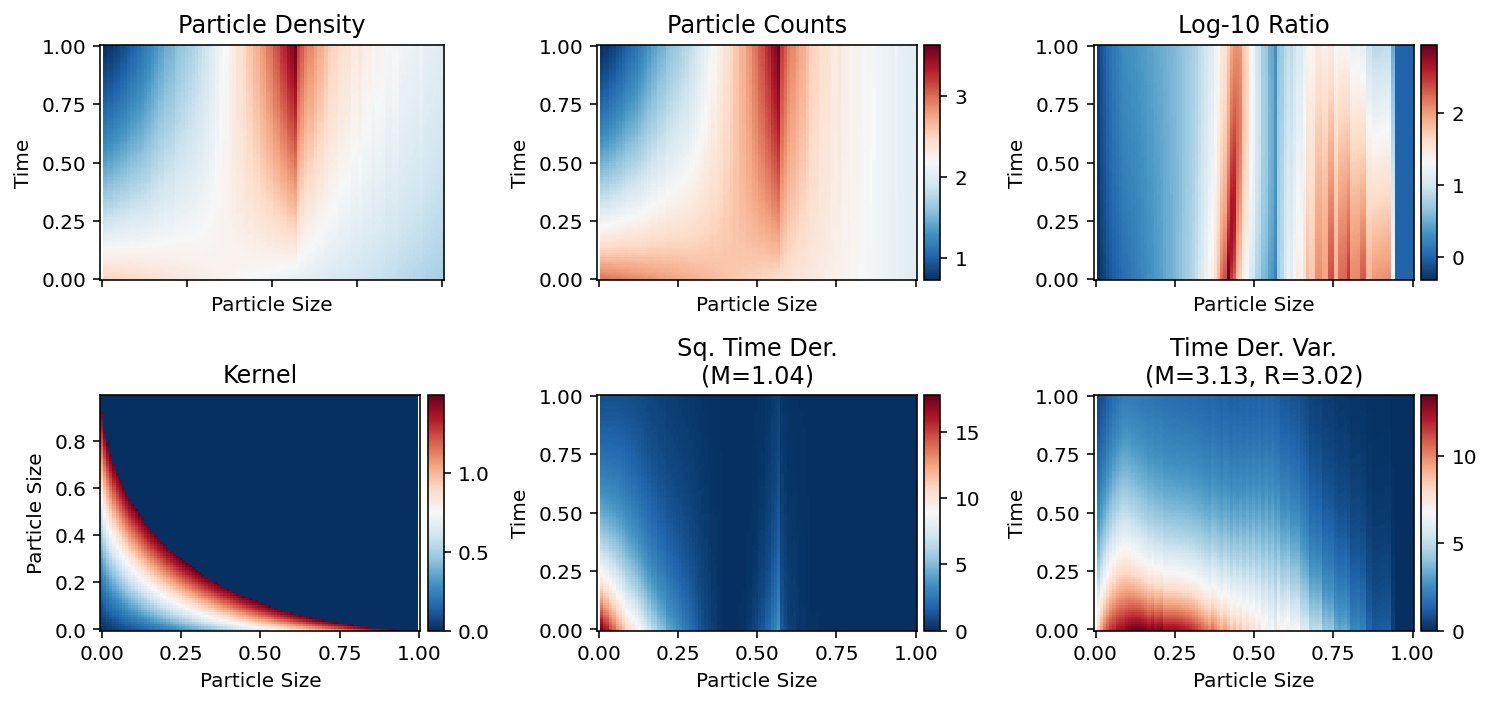

In [13]:
########################################
################ Plotting ##############
########################################
fig = None
if ex_dim == 1:
    x_plt = ex_x_grid1d.detach().cpu().numpy().ravel()
    y_plt = ex_t_g.detach().cpu().numpy() * 1.01
    c_plt1 = ex_rho_gpdf_np
    c_plt2 = ex_rho_g_np
    c_plt3 = ex_smsolver.K_2d.detach().cpu().numpy()
    c_plt4 = ex_drhodt_g_sq_np
    c_plt5 = ex_drhodt_var_g_np

    n_rows, n_cols = 2, 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3.5, n_rows*2.5), 
        dpi=72, sharex=True, sharey=False)

    def plot_rho_vs_xt(x_plt, y_plt, c_plt, fig, ax, add_cb=True):
        im = ax.pcolor(x_plt, y_plt, c_plt, linewidth=0, cmap='RdBu_r',
                       rasterized=True, shading='auto')
        if add_cb:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im, cax=cax)
        return fig, ax

    ax = axes[0, 0]
    plot_rho_vs_xt(x_plt, y_plt, c_plt1, fig, ax, add_cb=False)
    ax.set_title('Particle Density')
    ax.set_xlabel('Particle Size')
    ax.set_ylabel('Time')

    ax = axes[0, 1]
    plot_rho_vs_xt(x_plt, y_plt, c_plt2, fig, ax)
    ax.set_title('Particle Counts')
    ax.set_xlabel('Particle Size')
    ax.set_ylabel('Time')

    ax = axes[1, 0]
    plot_rho_vs_xt(x_plt-0.01, x_plt-0.01, c_plt3, fig, ax)
    ax.set_title('Kernel')
    ax.set_xlabel('Particle Size')
    ax.set_ylabel('Particle Size')

    ax = axes[1, 1]
    plot_rho_vs_xt(x_plt, y_plt, c_plt4, fig, ax)
    ax.set_title(f'Sq. Time Der.\n(M={c_plt4.mean():.2f})')
    ax.set_xlabel('Particle Size')
    ax.set_ylabel('Time')

    ax = axes[1, 2]
    plot_rho_vs_xt(x_plt, y_plt, c_plt5, fig, ax)
    ax.set_title(f'Time Der. Var.\n(M={c_plt5.mean():.2f}, R={c_plt5.mean() / c_plt4.mean():.2f})')
    ax.set_xlabel('Particle Size')
    ax.set_ylabel('Time')

    ax = axes[0, 2]
    plot_rho_vs_xt(x_plt, y_plt, np.log10(1e-2 + c_plt5) - np.log10(1e-2 + c_plt4), fig, ax)
    ax.set_title(f'Log-10 Ratio')
    ax.set_xlabel('Particle Size')
    ax.set_ylabel('Time')

    fig.set_tight_layout(True)
    
fig

### Utitlity functions

In [14]:
def get_nn_sol(model, x, n_eval=None, out_lib='numpy'):
    """
    Gets a model and evaluates it minibatch-wise on the tensor x. 
    The minibatch size is capped at n_eval. The output will have the 
    predicted potentials and the vector fields at them.

    Parameters
    ----------
    model: (nn.module) the batched neural network.

    x: (torch.tensor) the evaluation points. This array should be 
        >2-dimensional and have a shape of `(..., x_rows, x_cols)`.

    n_eval: (int or None) the maximum mini-batch size. If None is 
        given, `x_rows` will be used as `n_eval`.
    
    Output Dictionary
    ----------
    rho_np: (np.array) the evaluated potentials with a shape of
        `(*model.shape, x_rows)` where model.shape is 
        the batch dimensions of the model. 
    """
    x_rows, x_cols = tuple(x.shape)[-2:]
    x_bd_ = tuple(x.shape)[:-2]
    x_bd = (1,) if len(x_bd_) == 0 else x_bd_
    msg_ = f'Cannot have {x.shape} fed to {model.shape}'
    assert len(x_bd) <= model.ndim, msg_
    if len(x_bd) < model.ndim:
        x_bd = tuple([1] * (model.ndim-len(x_b)) + list(x_bd))
    assert all((a == b) or (a == 1) or (b == 1) 
               for a, b in zip(x_bd, model.shape)), msg_
    n_eval = x_rows if n_eval is None else n_eval

    if out_lib == 'numpy':
        to_lib = lambda a: a.detach().cpu().numpy()
        lib_cat = lambda al: np.concatenate(al, axis=1)
        lpf = '_np'
    elif out_lib == 'torch':
        to_lib = lambda a: a
        lib_cat = lambda al: torch.cat(al, dim=1)
        lpf = ''
    else:
        raise ValueError(f'outlib={outlib} not defined.')

    n_batches = int(np.ceil(x_rows / n_eval))
    rho_pred_list = []
    for i in range(n_batches):
        x_i = x[..., (i*n_eval):((i+1)*n_eval), :]
        xi_rows = x_i.shape[-2]
        x_ii = x_i.reshape(*x_bd, xi_rows, x_cols)
        x_iii = x_ii.expand(*model.shape, xi_rows, x_cols)

        rho_pred_i = model(x_iii)
        rho_pred_list.append(to_lib(rho_pred_i.squeeze(-1)))

    rho_pred = lib_cat(rho_pred_list)

    outdict = {f'rho{lpf}': rho_pred}
    return outdict


def plot_sol(x1_msh_np, x2_msh_np, y_msh_np, fig=None, ax=None, cax=None):
    dim = x1_msh_np.ndim
    assert dim == 2, f'dim={dim}, x1_msh_np.shape={x1_msh_np.shape}'
    (n_gpd1, n_gpd2) = x1_msh_np.shape
    assert x1_msh_np.shape == (n_gpd1, n_gpd2)
    assert x2_msh_np.shape == (n_gpd1, n_gpd2)
    n_g = n_gpd1 * n_gpd2
   
    if fig is None:
        assert ax is None
        assert cax is None
        fig, ax = plt.subplots(1, 1, figsize=(3.0, 2.5), dpi=72)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
    else:
        assert ax is not None
    
    y_msh_np_ = y_msh_np.reshape(-1, n_gpd1, n_gpd2).mean(axis=0)
    im = ax.pcolormesh(x1_msh_np, x2_msh_np, y_msh_np_,
        shading='auto', cmap='RdBu')
    if cax is not None:
        fig.colorbar(im, cax=cax)

    return fig, ax, cax

### Defining the Sampler

In [15]:
class XSampler:
    def __init__(self, batch_rng):
        self.batch_rng = batch_rng
    
    def np_exlinspace(self, start, end, n):
        assert n >= 1
        a = np.linspace(start, end, n, endpoint=False) 
        b = a + 0.5 * (end - a[-1])
        return b
    
    def tch_exlinspace(self, start, end, n):
        assert n >= 1
        a = torch.linspace(start, end, n+1, device=self.batch_rng.device, 
            dtype=self.batch_rng.dtype)[:-1] 
        b = a + 0.5 * (end - a[-1])
        return b
    
    def __call__(self, xi, n_j, do_detspacing=True):
        n_i, dim = xi.shape[-2:]
        mb_shape = xi.shape[:-2]
        n_bch = int(np.prod(mb_shape))
        
        xi = xi.reshape(n_bch, n_i, dim)
        assert xi.shape == (n_bch, n_i, dim)
        
        use_np = not torch.is_tensor(xi)
        exlinspace = self.np_exlinspace if use_np else self.tch_exlinspace
        
        if do_detspacing:
            n_jpd = int(n_j ** (1./dim))
            assert n_j == (n_jpd ** dim)
            
            unispd = exlinspace(0.0, 1.0, n_jpd)
            assert unispd.shape == (n_jpd,)
            
            unis = torch.cat([unispd.repeat_interleave(n_jpd**(dim-i-1), dim=0).repeat(
                (n_jpd**i,)).reshape(n_j, 1) for i in range(dim)], dim=1)
            assert unis.shape == (n_j, dim)
            
            xj_tilde = unis.reshape(1, 1, n_j, dim).expand(n_bch, n_i, n_j, dim)
            assert xj_tilde.shape == (n_bch, n_i, n_j, dim)
        elif (not do_detspacing) and (not use_np):
            xj_tilde = self.batch_rng.uniform((n_bch, n_i, n_j, dim))
            assert xj_tilde.shape == (n_bch, n_i, n_j, dim)
        else:
            raise RuntimeError('Not implemented yet!')
        
        xj = xj_tilde * xi.reshape(n_bch, n_i, 1, dim)
        assert xj.shape == (n_bch, n_i, n_j, dim)
        
        areas = xi.prod(dim=-1)
        assert areas.shape == (n_bch, n_i)
        
        areas = areas.reshape(*mb_shape, n_i)
        assert areas.shape == (*mb_shape, n_i)
        
        xj = xj.reshape(*mb_shape, n_i, n_j, dim)
        assert xj.shape == (*mb_shape, n_i, n_j, dim)
        
        ret_dict = dict(points=xj, areas=areas)
        return ret_dict

## JSON Config Loading and Preprocessing

In [ ]:
json_cfgpath = f'../configs/02_smoll/02_mse.yml'
! rm -rf "./10_smoluchowski/results/02_mse.h5"
! rm -rf "./10_smoluchowski/storage/02_mse"

if json_cfgpath.endswith('.json'):
    with open(json_cfgpath, 'r') as fp:
        json_cfgdict = json.load(fp, object_pairs_hook=odict)
elif json_cfgpath.endswith('.yml'):
    with open(json_cfgpath, "r") as fp:
        json_cfgdict = odict(yaml.safe_load(fp))
else:
    raise RuntimeError(f'unknown config extension: {json_cfgpath}')

json_cfgdict['io/config_id'] = '02_mse'
json_cfgdict['io/results_dir'] = './10_smolluchowski/results'
json_cfgdict['io/storage_dir'] = './10_smolluchowski/storage'
json_cfgdict['io/tch/device'] = 'cuda:0' if torch.cuda.is_available() else 'cpu'

all_cfgdicts = preproc_cfgdict(json_cfgdict)
cfg_dict_input = all_cfgdicts[0]

## Retrieving Config Variables

In [ ]:
    cfg_dict = cfg_dict_input.copy()

    #########################################################
    #################### Ignored Options ####################
    #########################################################
    cfgdesc = cfg_dict.pop('desc', None)
    cfgdate = cfg_dict.pop('date', None)

    #########################################################
    ################### Mandatory Options ###################
    #########################################################
    prob_type = cfg_dict.pop('problem')
    rng_seed_list = cfg_dict.pop('rng_seed/list')
    dim = cfg_dict.pop('dim')
    real_n_j = cfg_dict.pop('pts/n')
    do_detspacing = cfg_dict.pop('pts/detspc')

    n_i = cfg_dict.pop('eq/n')
    eq_t_dstr = cfg_dict.pop('eq/t/dstr')
    if eq_t_dstr == 'delta':
        eq_t_loc_dstr = cfg_dict.pop('eq/t/loc/dstr')
        msg_ = f'"eq/t/loc/dstr"="uniform" is only supported.'
        assert eq_t_loc_dstr == 'uniform', msg_
        eq_t_loc_low_ = cfg_dict.pop('eq/t/loc/low')
        eq_t_loc_high_ = cfg_dict.pop('eq/t/loc/high')
    elif eq_t_dstr == 'uniform':
        eq_t_low_dstr = cfg_dict.pop('eq/t/low/dstr', 'fixed')
        if eq_t_low_dstr == 'fixed':
            eq_t_low_low_ = eq_t_low_high_ = cfg_dict.pop('eq/t/low')
        elif eq_t_low_dstr == 'ic/t':
            ic_t_dstr_temp = cfg_dict.get('ic/t/dstr', 'fixed')
            if ic_t_dstr_temp == 'fixed':
                eq_t_low_low_ = eq_t_low_high_ = cfg_dict.get('ic/t')
            elif ic_t_dstr_temp == 'uniform':
                eq_t_low_low_ = cfg_dict.get('ic/t/low')
                eq_t_low_high_ = cfg_dict.get('ic/t/high')
            else:
                msg_ = f'eq/t/low/dstr="ic/t", and ic/t is neither fixed nor uniform'
                raise ValueError(msg_)
        elif eq_t_low_dstr == 'uniform':
            eq_t_low_low_ = cfg_dict.pop('eq/t/low/low')
            eq_t_low_high_ = cfg_dict.pop('eq/t/low/high')
        else:
            raise ValueError(f'eq/t/low/dstr="{eq_t_low_dstr}" not supported')
        
        eq_t_high_dstr = cfg_dict.pop('eq/t/high/dstr', 'fixed')
        if eq_t_high_dstr == 'fixed':
            eq_t_high_low_ = eq_t_high_high_ = cfg_dict.pop('eq/t/high')
        elif eq_t_high_dstr == 'uniform':
            eq_t_high_low_ = cfg_dict.pop('eq/t/high/low')
            eq_t_high_high_ = cfg_dict.pop('eq/t/high/high')
        else:
            raise ValueError(f'eq/t/high/dstr="{eq_t_high_dstr}" not supported')
    else:
        raise ValueError(f'eq/t/dstr="{t_dstr}" is not implemented')
    
    eq_x_dstr = cfg_dict.pop('eq/x/dstr')
    if eq_x_dstr == 'uniform':
        eq_x_low_dstr = cfg_dict.pop('eq/x/low/dstr', 'fixed')
        assert eq_x_low_dstr == 'fixed', '"eq/x/low/dstr" must be fixed'
        eq_x_low_ = cfg_dict.pop('eq/x/low')
        
        eq_x_high_dstr = cfg_dict.pop('eq/x/high/dstr', 'fixed')
        assert eq_x_high_dstr == 'fixed', '"eq/x/high/dstr" must be fixed'
        eq_x_high_ = cfg_dict.pop('eq/x/high')
    else:
        raise ValueError(f'eq/x/dstr="{x_dstr}" not supported')

    do_bootstrap = cfg_dict.pop('trg/btstrp')
    if do_bootstrap:
        tau = cfg_dict.pop('trg/tau')
        w_tr = cfg_dict.pop('trg/reg/w')
    else:
        w_tr = 0.0

    opt_type = cfg_dict.pop('opt/dstr')
    n_epochs = cfg_dict.pop('opt/epoch')
    lr = cfg_dict.pop('opt/lr')

    #########################################################
    ################## Neural Spec Options ##################
    #########################################################
    nn_dstr = cfg_dict.pop('nn/dstr')
    if nn_dstr == 'mlp':
        nn_width = cfg_dict.pop('nn/width')
        nn_hidden = cfg_dict.pop('nn/hidden')
        nn_act = cfg_dict.pop('nn/act')
    else:
        msg_ = f'nn/dstr="{nn_dstr}" not defined!'
        raise ValueError(msg_)

    #########################################################
    ############### Initial Condition Options ###############
    #########################################################
    ic_dstr = cfg_dict.pop('ic/dstr')
    w_ic = cfg_dict.pop('ic/w')
    ic_n = cfg_dict.pop('ic/n')
    ic_t_dstr = cfg_dict.pop('ic/t/dstr', 'fixed')
    ic_x_dstr = cfg_dict.pop('ic/x/dstr', 'fixed')
    
    if ic_dstr in ('linear',):
        ic_bias_ = cfg_dict.pop('ic/bias')
        ic_slope_ = cfg_dict.pop('ic/slope')
    elif ic_dstr in ('gmm',):    
        ic_k = cfg_dict.pop('ic/k')
        ic_mix_ = cfg_dict.pop('ic/mix')
        ic_loc_ = cfg_dict.pop('ic/loc')
        ic_scale_ = cfg_dict.pop('ic/scale')
        ic_bias_ = cfg_dict.pop('ic/bias')
        ic_slope_ = cfg_dict.pop('ic/slope')
    else:
        msg_ = f'ic/dstr={ic_dstr} not defined'
        raise ValueError(msg_)
    
    if ic_t_dstr in ('fixed',):
        ic_t = cfg_dict.pop('ic/t')
    else:
        msg_ = f'ic/t/dstr={ic_t_dstr} not defined'
        raise ValueError(msg_)
    
    if ic_x_dstr == 'eq/x':
        pass
    elif ic_x_dstr == 'uniform':
        ic_x_low_ = cfg_dict.pop('ic/x/low')
        ic_x_high_ = cfg_dict.pop('ic/x/high')
    else:
        msg_ = f'ic/x/dstr={ic_x_dstr} not defined'
        raise ValueError(msg_)
    
    #########################################################
    ############## Smolluchowski Kernel Options #############
    #########################################################
    ker_dstr = cfg_dict.pop('ker/dstr')
    assert ker_dstr == 'pnorm', f'ker/dstr="{ker_dstr}" not supported'
    
    ker_pnorm_ = cfg_dict.pop('ker/norm/p')
    ker_maxnorm_ = cfg_dict.pop('ker/norm/max')
    ker_slope_ = cfg_dict.pop('ker/slope')
    ker_alpha_ = cfg_dict.pop('ker/alpha')
    ker_beta_ = cfg_dict.pop('ker/beta')
    ker_gamma_ = cfg_dict.pop('ker/gamma')

    #########################################################
    ########### Evaluation Point Sampling Options ###########
    #########################################################
    eid_list_dup = [opt.split('/')[1] for opt in cfg_dict
                    if opt.startswith('eval/')]
    eid_list = list(odict.fromkeys(eid_list_dup))
    evalcfgs = odict()
    for eid in eid_list:
        evalcfgs[eid] = odict()
        cfgopts = list(cfg_dict.keys())
        for opt in cfgopts:
            prfx = f'eval/{eid}/'
            if opt.startswith(prfx):
                optn = opt[len(prfx):]
                optv = cfg_dict.pop(opt)
                evalcfgs[eid][optn] = optv

    #########################################################
    ################# I/O Logistics Options #################
    #########################################################
    config_id = cfg_dict.pop('io/config_id')
    results_dir = cfg_dict.pop('io/results_dir')
    storage_dir = cfg_dict.pop('io/storage_dir', None)
    io_avgfrq = cfg_dict.pop('io/avg/frq')
    ioflsh_period = cfg_dict.pop('io/flush/frq')
    chkpnt_period = cfg_dict.pop('io/ckpt/frq')
    device_name = cfg_dict.pop('io/tch/device')
    dtype_name = cfg_dict.pop('io/tch/dtype')
    iomon_period = cfg_dict.pop('io/mon/frq')
    io_cmprssnlvl = cfg_dict.pop('io/cmprssn_lvl')
    eval_bs = cfg_dict.pop('io/eval/bs', None)

    dtnow = datetime.datetime.now().isoformat(timespec='seconds')
    hostname = socket.gethostname()
    commit_hash = get_git_commit()
    cfg_tree = '/'.join(config_id.split('/')[:-1])
    cfg_name = config_id.split('/')[-1]
    #########################################################
    ##################### Sanity Checks #####################
    #########################################################

    # Making sure the specified option distributions are implemented.
    fixed_opts = ['desc', 'date', 'rng_seed/list', 'problem',
                  'dim', 'pts/n', 'pts/detspc', 'trg/btstrp', 
                  'trg/w', 'trg/reg/w', 'trg/tau', 'opt/lr', 
                  'opt/epoch', 'pts/n', 'pts/detspc', 'eq/n', 
                  'ic/t', 'ic/bias', 'ic/slope', 'ic/w',
                  'ic/mix', 'ic/loc', 'ic/scale', 'ic/x/low', 
                  'ic/x/high', 'ker/norm/p', 'ker/norm/max', 
                  'ker/slope', 'ker/alpha', 'ker/beta', 'ker/gamma',
                  'nn/width', 'nn/hidden', 'nn/act']

    opt2availdstrs = {**{opt: ('fixed',) for opt in fixed_opts},
        'nn': ('mlp',),  'eq/x': ('uniform',), 'eq/x/low': ('fixed',), 
        'eq/x/high': ('fixed',), 'eq/t': ('delta', 'uniform'),
        'eq/t/low': ('fixed', 'uniform', 'ic/t'), 'eq/t/high': ('fixed', 'uniform',),
        'ic': ('linear', 'gmm'), 'ker': ('pnorm',), 'ic/x': ('eq/x', 'uniform'),
        **{f'eval/{eid}': ('grid',) for eid in eid_list},
        **{f'eval/{eid}/x': ('uniform', 'eq/x') for eid in eid_list},
        **{f'eval/{eid}/t': ('uniform', 'eq/t') for eid in eid_list}}

    for opt, avail_dstrs in opt2availdstrs.items():
        opt_dstr = cfg_dict_input.get(f'{opt}/dstr', 'fixed')
        msg_  = f'"{opt}" cannot follow the "{opt_dstr}" distribution or type '
        msg_ += f'since it is not implemented or available at least yet. The '
        msg_ += f'only available options for "{opt}" are {avail_dstrs}.'
        assert opt_dstr in avail_dstrs, msg_

    # Making sure no other options are left unused.
    if len(cfg_dict) > 0:
        msg_ = f'The following settings were left unused:\n'
        for key, val in cfg_dict.items():
            msg_ += f'  {key}: {val}'
        raise RuntimeError(msg_)

    # Making sure that all "*_dstr" options are valid
    dstr2args = {'uniform':  ('/low', '/high'),
                 'gmm':      ('/k', '/mix', '/loc', '/scale', 
                              '/bias', '/slope'),
                 'linear':   ('/bias', '/slope'),
                 'delta':    ('/loc',),
                 'pnorm':    ('/norm/p', '/norm/max', '/slope', 
                              '/alpha', '/beta', '/gamma'),
                 'eq/x':     (), 'ic/t': (),
                 'fixed':    ('',)}

    key2req = {'ic': ('/w', '/t', '/x')}
    for key in ['eq/x', 'eq/t', 'ker', 'ic']:
        chck_dstrargs(key, cfg_dict_input, dstr2args, key2req)

    edstr2args = {'uniform': ('/low', '/high', '/n'),
                  'grid':    ('/t', '/x', '/frq'),
                  'eq/t':    ('/n',), 'eq/x': ('/n',),
                  'fixed':   ('',)}
    for eid in eid_list:
        chck_dstrargs(f'eval/{eid}', cfg_dict_input, 
            edstr2args, None)

    # To estimate the integration variance in an unbiased manner, 
    # we need at least two samples per equation. When `n_j` is one, 
    # this becomes difficult. Therefore, when `n_j=1`, we sample 2  
    # points per equation, but only use one of them in the gradient 
    # calculation. This is done in the subsetting of the `sum1` and 
    # `sum2` variables.
    n_j = max(2, real_n_j)
    
    if eval_bs is None:
        eval_bs = n_i * n_j
        
    #########################################################
    ########### I/O-Related Options and Operations ##########
    #########################################################

    name2dtype = dict(float64=torch.double,
                      float32=torch.float32,
                      float16=torch.float16)
    tch_device = torch.device(device_name)
    tch_dtype = name2dtype[dtype_name]

    tch_dvcmdl = device_name
    if device_name.startswith('cuda'):
        tch_dvcmdl = torch.cuda.get_device_name(tch_device)

    # Reserving 15.596 GB of memory for later usage
    t_gpumem = torch.cuda.get_device_properties(tch_device).total_memory
    tdt_elsize = torch.tensor(1).to(tch_device, tch_dtype).element_size()
    nuslss = int((0.00 * t_gpumem) / tdt_elsize)
    useless_tensor = torch.empty((nuslss,), device=tch_device, dtype=tch_dtype)
    del useless_tensor
    
    msg_ = f'"io/mon/frq" % "io/avg/frq" != 0'
    assert iomon_period % io_avgfrq == 0, msg_
    msg_ = f'"io/ckpt/frq" % "io/avg/frq" != 0'
    assert chkpnt_period % io_avgfrq == 0, msg_
    
    do_logtb = storage_dir is not None
    do_profile = storage_dir is not None
    do_tchsave = storage_dir is not None
    
    assert not(do_logtb) or (storage_dir is not None)
    assert not(do_profile) or (storage_dir is not None)
    assert not(do_tchsave) or (storage_dir is not None)
    
    #########################################################
    ########### Constructing the Batch RNG Object ###########
    #########################################################
    n_seeds = len(rng_seed_list)
    rng_seeds = np.array(rng_seed_list)
    rng = BatchRNG(shape=(n_seeds,), lib='torch',
                   device=tch_device, dtype=tch_dtype,
                   unif_cache_cols=1_000_000,
                   norm_cache_cols=5_000_000)
    rng.seed(np.broadcast_to(rng_seeds, rng.shape))
    
    #########################################################
    ####### Defining the Smolluchowski Problem Object #######
    #########################################################
    assert prob_type == 'smolluchowski'
    assert ker_dstr == 'pnorm', f'ker/dstr="{ker_dstr}" not supported'
    
    get_kernel = CustomKernel(pnorm=ker_pnorm_, maxnorm=ker_maxnorm_, 
        slope=ker_slope_, alpha=ker_alpha_, beta=ker_beta_, 
        gamma=ker_gamma_)
    
    #########################################################
    ####### Defining the Initial Condition Parameters #######
    #########################################################
    trns_opts = dict(dim=dim, sqrt=np.sqrt)
    
    if ic_dstr == 'linear':
        ic_bias = get_arr('ic_bias', '()', 
            {**trns_opts, 'ic_bias': ic_bias_})
        assert ic_bias.shape == tuple()
        
        ic_slope = get_arr('ic_slope', '(dim,)', 
            {**trns_opts, 'ic_slope': ic_slope_})
        assert ic_slope.shape == (dim,)
        
        ic_bias_tch = torch.from_numpy(ic_bias).to(dtype=tch_dtype, device=tch_device)
        ic_slope_tch = torch.from_numpy(ic_slope).to(dtype=tch_dtype, device=tch_device)
        get_rhoinit = RhoLin(ic_bias_tch, ic_slope_tch, t_ic=ic_t)
    elif ic_dstr == 'gmm':
        trns_opts['ic_k'] = ic_k
        
        ic_mix = get_arr('ic_mix', '(ic_k,)', {**trns_opts, 'ic_mix': ic_mix_})
        assert ic_mix.shape == (ic_k,)
        
        ic_loc = get_arr('ic_loc', '(ic_k, dim)', {**trns_opts, 'ic_loc': ic_loc_})
        assert ic_loc.shape == (ic_k, dim)
        
        ic_scale = get_arr('ic_scale', '(ic_k, dim)', {**trns_opts, 'ic_scale': ic_scale_})
        assert ic_scale.shape == (ic_k, dim)
        
        ic_bias = get_arr('ic_bias', '()', {**trns_opts, 'ic_bias': ic_bias_}).item()
        assert isinstance(ic_bias, float)
        
        ic_slope = get_arr('ic_slope', '()', {**trns_opts, 'ic_slope': ic_slope_}).item()
        assert isinstance(ic_slope, float)
        
        ic_mixtch = torch.from_numpy(ic_mix).to(dtype=tch_dtype, device=tch_device)
        ic_loctch = torch.from_numpy(ic_loc).to(dtype=tch_dtype, device=tch_device)
        ic_scaletch = torch.from_numpy(ic_scale).to(dtype=tch_dtype, device=tch_device)
        
        get_rhoinit = RhoGMM(mix=ic_mixtch, loc=ic_loctch, scale=ic_scaletch, 
            bias=ic_bias, slope=ic_slope, t_ic=ic_t)
    else:
        raise ValueError(f'ic_dstr={ic_dstr} not implemented.')
    
    assert isinstance(ic_n, int) or (ic_n == 'eq/n')
    n_ic = n_i if ic_n == 'eq/n' else ic_n
    
    if ic_x_dstr == 'eq/x':
        msg_ = f'when ic/x/dstr=="eq/x", ic/n must be leq eq/n'
        assert n_ic <= n_i, msg_
    elif ic_x_dstr == 'uniform':
        ic_x_low_0 = get_arr('ic_x_low', '(dim,)', 
            {**trns_opts, 'ic_x_low': ic_x_low_})
        ic_x_low = np.broadcast_to(ic_x_low_0[None, ...],
            (n_seeds, dim)).copy()
        assert ic_x_low.shape == (n_seeds, dim)
        
        ic_x_high_0 = get_arr('ic_x_high', '(dim,)', 
            {**trns_opts, 'ic_x_high': ic_x_high_})
        ic_x_high = np.broadcast_to(ic_x_high_0[None, ...],
            (n_seeds, dim)).copy()
        assert ic_x_high.shape == (n_seeds, dim)
        
        x_low_ic = torch.from_numpy(eq_x_low[..., None, :]).to(
            dtype=tch_dtype, device=tch_device)
        assert x_low_ic.shape == (n_seeds, 1, dim)
        
        x_high_ic = torch.from_numpy(eq_x_high[..., None, :]).to(
            dtype=tch_dtype, device=tch_device)
        assert x_high_ic.shape == (n_seeds, 1, dim)
        
        x_range_ic = x_high_ic - x_low_ic
        assert x_range_ic.shape == (n_seeds, 1, dim)
    else:
        raise ValueError(f'ic/x/dstr={ic_x_dstr} not implemented.')
    #########################################################
    ####### Defining the Point Sampling Parameteters ########
    #########################################################
    trns_opts = dict(dim=dim, sqrt=np.sqrt)
    
    # The smolluchowski x distribution
    if eq_x_low_dstr == 'fixed':
        eq_x_low_0 = get_arr('eq_x_low', '(dim,)', 
            {**trns_opts, 'eq_x_low': eq_x_low_})
        eq_x_low = np.broadcast_to(eq_x_low_0[None, ...],
            (n_seeds, dim)).copy()
        assert eq_x_low.shape == (n_seeds, dim)
    else:
        raise ValueError(f'eq_x_low_dstr={eq_x_low_dstr} '
                         'not implemented.')
        
    if eq_x_high_dstr == 'fixed':
        eq_x_high_0 = get_arr('eq_x_high', '(dim,)', 
            {**trns_opts, 'eq_x_high': eq_x_high_})
        eq_x_high = np.broadcast_to(eq_x_high_0[None, ...],
            (n_seeds, dim)).copy()
        assert eq_x_high.shape == (n_seeds, dim)
    else:
        raise ValueError(f'eq_x_high_dstr={eq_x_high_dstr} '
                         'not implemented.')
        
    # The smolluchowski t distribution    
    if eq_t_dstr == 'delta':
        do_integtime = False
        use_ic4tlow = False
        eq_t_loc_low_0 = get_arr('eq_t_loc_low', '()', 
            {**trns_opts, 'eq_t_loc_low': eq_t_loc_low_})
        eq_t_loc_low = np.broadcast_to(eq_t_loc_low_0[None, ...],
            (n_seeds,)).copy()
        assert eq_t_loc_low.shape == (n_seeds,)
        
        eq_t_loc_high_0 = get_arr('eq_t_loc_high', '()', 
            {**trns_opts, 'eq_t_loc_high': eq_t_loc_high_})
        eq_t_loc_high = np.broadcast_to(eq_t_loc_high_0[None, ...],
            (n_seeds,)).copy()
        assert eq_t_loc_high.shape == (n_seeds,)
    elif eq_t_dstr == 'uniform':
        do_integtime = True
        use_ic4tlow = (eq_t_low_dstr == 'ic/t')
        
        # eq/t/low variables -> eq_t_low_low, eq_t_low_high
        eq_t_low_low_0 = get_arr('eq_t_low_low', '()', 
            {**trns_opts, 'eq_t_low_low': eq_t_low_low_})
        eq_t_low_low = np.broadcast_to(eq_t_low_low_0[None, ...],
            (n_seeds,)).copy()
        assert eq_t_low_low.shape == (n_seeds,)
        
        eq_t_low_high_0 = get_arr('eq_t_low_high', '()', 
            {**trns_opts, 'eq_t_low_high': eq_t_low_high_})
        eq_t_low_high = np.broadcast_to(eq_t_low_high_0[None, ...],
            (n_seeds,)).copy()
        assert eq_t_low_high.shape == (n_seeds,)
        
        # eq/t/high variables -> eq_t_high_low, eq_t_high_high
        eq_t_high_low_0 = get_arr('eq_t_high_low', '()', 
            {**trns_opts, 'eq_t_high_low': eq_t_high_low_})
        eq_t_high_low = np.broadcast_to(eq_t_high_low_0[None, ...],
            (n_seeds,)).copy()
        assert eq_t_high_low.shape == (n_seeds,)
        
        eq_t_high_high_0 = get_arr('eq_t_high_high', '()', 
            {**trns_opts, 'eq_t_high_high': eq_t_high_high_})
        eq_t_high_high = np.broadcast_to(eq_t_high_high_0[None, ...],
            (n_seeds,)).copy()
        assert eq_t_high_high.shape == (n_seeds,)
    else:
        raise ValueError(f'eq/t/dstr="{eq_t_dstr}" not defined.')
    
    # Setting up the x sampler parameters
    x_low = torch.from_numpy(eq_x_low[..., None, :]).to(
        dtype=tch_dtype, device=tch_device)
    assert x_low.shape == (n_seeds, 1, dim)
    x_high = torch.from_numpy(eq_x_high[..., None, :]).to(
        dtype=tch_dtype, device=tch_device)
    assert x_high.shape == (n_seeds, 1, dim)
    x_range = x_high - x_low
    assert x_range.shape == (n_seeds, 1, dim)
    
    assert eq_x_dstr == 'uniform', 'XSampler only works with uniform x'
    xsampler = XSampler(rng)
    
    # Setting up the t sampler parameters
    if eq_t_dstr == 'delta':
        t_ll = torch.from_numpy(eq_t_loc_low).reshape(
            n_seeds, 1, 1).to(dtype=tch_dtype, device=tch_device)
        assert t_ll.shape == (n_seeds, 1, 1)
        
        t_hh = torch.from_numpy(eq_t_loc_high).reshape(
            n_seeds, 1, 1).to(dtype=tch_dtype, device=tch_device)
        assert t_hh.shape == (n_seeds, 1, 1)
        t_lh = t_hl = t_ll
    elif eq_t_dstr == 'uniform':
        t_ll = torch.from_numpy(eq_t_low_low).reshape(
            n_seeds, 1, 1).to(dtype=tch_dtype, device=tch_device)
        assert t_ll.shape == (n_seeds, 1, 1)
        
        t_lh = torch.from_numpy(eq_t_low_high).reshape(
            n_seeds, 1, 1).to(dtype=tch_dtype, device=tch_device)
        assert t_lh.shape == (n_seeds, 1, 1)
        
        t_hl = torch.from_numpy(eq_t_high_low).reshape(
            n_seeds, 1, 1).to(dtype=tch_dtype, device=tch_device)
        assert t_hl.shape == (n_seeds, 1, 1)
        
        t_hh = torch.from_numpy(eq_t_high_high).reshape(
            n_seeds, 1, 1).to(dtype=tch_dtype, device=tch_device)
        assert t_hh.shape == (n_seeds, 1, 1)
    else:
        raise ValueError(f'eq/t/dstr="{eq_t_dstr}" not defined')

    #########################################################
    #### Evaluation Param Tensorization and Sanitization ####
    #########################################################

    # The following evaluates the 'eval/*' options and creates 
    # array parameters for evaluation.
    # The input is mainly the `evalcfgs` dictionary, which holds 
    # some keys and list/string values. The output will be the 
    # `evalprms` dictionary which has the same keys but with 
    # np.array values.
    # --------------
    # Example input: 
    #   evalcfgs = {'ur': {'dstr': 'uniform', 
    #       'low': [0], 
    #       'high': '[sqrt(dim)]'}}
    # --------------
    # Example output
    #   evalprms = {'ur': {'dstr': 'uniform',
    #       'low' : torch.tensor([0]).expand(n_seeds, dim)
    #       'high': torch.tensor(np.sqrt(dim)).expand(n_seeds, dim))}}

    dstr2shapes = {'grid': {'t': {'uniform': {'low': '()', 'high': '()', 'n': '()'},
                                  'eq/t': {'n': '()'}}, 
                            'x': {'uniform': {'low': '(dim,)', 'high': '(dim,)', 'n': '()'},
                                  'eq/x': {'n': '()'}}}
                   }

    assert all('dstr' in eopts for eopts in evalcfgs.values())
    assert all('frq'  in eopts for eopts in evalcfgs.values())
    assert all('bs'   in eopts for eopts in evalcfgs.values())
    evalprms = odict()
    for eid, eopts_ in evalcfgs.items():
        eopts = eopts_.copy()
        eparam = odict()
        for eopt in ('dstr', 'frq', 'bs'):
            eparam[eopt] = eopts.pop(eopt)

        edstr = eparam['dstr']
        msg_  = f'Unknown eval "{eid}" dstr -> "{edstr}". '
        msg_ += f'dstr should be one of {dstr2shapes.keys()}.'
        assert edstr in dstr2shapes, msg_

        opt_dstr2shapes = dstr2shapes[edstr]
        for eopt1, dstr2shapes1 in opt_dstr2shapes.items():
            # Example: eopt1 = 'x'
            #          edstr1 = 'uniform'
            #          opts2shape = {'low': '(dim,)', 'high': '(dim,)'}
            edstr1 = eopts.pop(f'{eopt1}/dstr', 'fixed')
            
            msg_  = f'Unknown eval "{eid}/{eopt1}" dstr -> "{edstr1}". '
            msg_ += f'dstr should be one of {dstr2shapes1.keys()}.'
            assert edstr1 in dstr2shapes1, msg_
            
            eparam[f'{eopt1}/dstr'] = edstr1
            
            opts2shape = dstr2shapes1[edstr1]
            for eopt2, eopt2_shpstr in opts2shape.items():
                # Example: edstr1 = 'uniform'
                #          eopt2 = 'low'
                #          eopt1 = 'x'
                #          eopt  = 'x/low'
                #          eopt2_shpstr = '(dim,)'
                #          eopt2_shp = (dim,)
                #          eopt2_val = "[sqrt(dim)]"
                #          eopt2_pnp0 = np.array([sqrt(dim)]*dim)
                #          eopt2_pnp0.shape = (dim,)
                #          eopt2_pnp = eopt2_pnp0.expand(n_seeds, dim)
                #          eopt2_pnp.shape = (n_seeds, dim)
                #          eopt2_p = torch.from_numpy(eopt2_pa0)
                #          eopt2_p.shape = (n_seeds, dim)
                eopt = f'{eopt1}/{eopt2}'
                msg_  = f'"eval/{eid}/{eopt}" must be fixed and determined.'
                msg_ += f' Hierarchical support not available yet.'
                assert eopt in eopts, msg_

                eopt2_val = eopts.pop(eopt)
                etrns = {eopt2: eopt2_val, 'dim': dim, 
                        'sqrt': np.sqrt}

                eopt2_pnp0 = get_arr(eopt2, eopt2_shpstr, etrns)        
                eopt2_shp = eval_formula(eopt2_shpstr, {'dim': dim})
                eopt2_pnp = np.broadcast_to(eopt2_pnp0[None, ...],
                                        (n_seeds, *eopt2_shp)).copy()
                assert eopt2_pnp.shape == (n_seeds, *eopt2_shp)
                eopt2_pc = torch.from_numpy(eopt2_pnp)
                eopt2_p = eopt2_pc.to(device=tch_device, dtype=tch_dtype)
                assert eopt2_p.shape == (n_seeds, *eopt2_shp)
                eparam[eopt] = eopt2_p

        assert len(eopts) == 0, f'unused eval items left: {eopts}'
        evalprms[eid] = eparam

    #########################################################
    ############# Evaluation Parameter Creation #############
    #########################################################
    for eid, eopts in evalprms.items():
        edstr = eopts['dstr']
        if edstr == 'grid':
            # extracting the grid sizes
            n_t_arr = eopts['t/n']
            assert n_t_arr.shape == (n_seeds,)
            n_x_arr = eopts['x/n']
            assert n_x_arr.shape == (n_seeds,)
            assert (n_x_arr == n_x_arr[:1]).all()
            assert (n_t_arr == n_t_arr[:1]).all()
            
            n_t = int(n_t_arr[0].item())
            n_g = int(n_x_arr[0].item())
            n_gpd = int(np.ceil(n_g ** (1.0/dim)))
            msg_ = 'Only full dim-powers can be set as "eval/*/n/x"'
            assert (n_gpd ** dim) == n_g, msg_
            eopts['bs'] = eopts['bs'] if eopts['bs'] > 0 else (n_t * n_g)
            assert eopts['bs'] <= (n_t * n_g)

            # The x distribution of the grid
            e_x_dstr = eopts.get(f'x/dstr', 'fixed')
            if e_x_dstr == 'uniform':
                e_x_low, e_x_high = eopts['x/low'], eopts['x/high']
            elif e_x_dstr == 'eq/x':
                assert eq_x_low_dstr == 'fixed'
                assert eq_x_high_dstr == 'fixed'
                e_x_low  = torch.from_numpy(eq_x_low ).to(device=tch_device, dtype=tch_dtype)
                e_x_high = torch.from_numpy(eq_x_high).to(device=tch_device, dtype=tch_dtype)
            else:
                msg_ = f'eval/{eid}/x/dstr={e_x_dstr} not defined.'
                raise ValueError(msg_)
            assert e_x_low.shape == (n_seeds, dim)
            msg_ = f'eval/{eid}/x/low != 0 not supported.'
            assert (e_x_low == 0.0).all(), msg_
            assert e_x_high.shape == (n_seeds, dim)
            assert (e_x_high == e_x_high[:1, :]).all()
            e_x_high_0 = e_x_high[0]
            
            # The t distribution of the grid
            e_t_dstr = eopts.get(f't/dstr', 'fixed')
            if e_t_dstr == 'uniform':
                e_t_low, e_t_high = eopts['t/low'], eopts['t/high']
            elif e_t_dstr == 'eq/t':
                msg_ = f"""
                For grid evaluations, 'eq/t' must define a uniform 
                distribution over the sampled time points. 
                
                Assuming 
                    t_1 = eq/t/low/low,
                    t_2 = eq/t/low/high,
                    t_3 = eq/t/high/low, and
                    t_4 = eq/t/high/high
                then, either 
                    (t_1 == t_2 == t_3), or 
                    (t_2 == t_3 == t_4) 
                must hold for the sampled times to be uniform.
                """
                if eq_t_dstr == 'uniform':
                    assert (eq_t_low_high == eq_t_high_low).all(), dedent(msg_)
                    assert ((eq_t_low_low == eq_t_low_high).all() or 
                            (eq_t_high_low == eq_t_high_high)), dedent(msg_)
                    e_t_low, e_t_high =  eq_t_low_low, eq_t_high_high
                elif eq_t_dstr == 'delta':
                    e_t_low, e_t_high =  eq_t_loc_low, eq_t_loc_high
                else:
                    raise ValueError(f'eq/t/dstr={eq_t_dstr} not defined')
            else:
                msg_ = f'eval/{eid}/t/dstr={e_t_dstr} not defined.'
                raise ValueError(msg_)
            assert e_t_low.shape == (n_seeds,)
            assert (e_t_low == e_t_low[:1]).all()
            assert e_t_high.shape == (n_seeds,)
            assert (e_t_high == e_t_high[:1]).all()
            e_t_low_0 = e_t_low[0]
            e_t_high_0 = e_t_high[0]
            
            print_gpumem_stat(tch_device)
            smsolver = SMSum(dim, n_gpd, e_x_high_0, get_kernel)
            print_gpumem_stat(tch_device)
            x_grid1d = smsolver.get_x()
            assert x_grid1d.shape == (n_g, dim)
            rho_init = get_rhoinit(x_grid1d)
            assert rho_init.shape == (n_g,)

            t_g = torch.linspace(e_t_low_0, e_t_high_0, n_t, dtype=tch_dtype, device=tch_device)
            rho_g = torch.zeros(n_t, n_g, dtype=tch_dtype, device=tch_device)
            drhodt_g = torch.zeros(n_t, n_g, dtype=tch_dtype, device=tch_device)
            drhodt_var_g = torch.zeros(n_t, n_g, dtype=tch_dtype, device=tch_device)
            rho_g[0, :] = rho_t = rho_init
            for t in range(1, n_t):
                soldict = smsolver(rho_t, summer='efficient')
                influx = soldict['influx']
                outflux = soldict['outflux']
                influxsq = soldict['influxsq']
                outfluxsq = soldict['outfluxsq']
                drhodt_t = (influx - outflux)
                drhodt_var_t = (outfluxsq - outflux.square()) + (influxsq - influx.square())
                rho_g[t, :] = rho_t = rho_t + drhodt_t * (t_g[t] - t_g[t-1])
                drhodt_g[t-1, :] = drhodt_t
                drhodt_var_g[t-1, :] = drhodt_var_t
            drhodt_g[-1, :] = drhodt_t
            drhodt_var_g[-1, :] = drhodt_var_t
            
            if dim == 1:
                eopts['k2d_np'] = smsolver.K_2d.detach().cpu().numpy()

            del smsolver
            print_gpumem_stat(tch_device)

            rho_g_np = rho_g.detach().cpu().numpy()
            rho_gpdf_np = rho_g_np / rho_g_np.sum(axis=1, keepdims=True)
            drhodt_g_np = drhodt_g.detach().cpu().numpy()
            drhodt_var_g_np = drhodt_var_g.detach().cpu().numpy()
            drhodt_g_sq_np = drhodt_g.square().detach().cpu().numpy()

            aa, bb = drhodt_g_sq_np.mean(), drhodt_var_g_np.mean()
            if be_verbose:
                print('*'*50)
                print(f'Mean Squared Time Derivative  = {aa:.4f}')
                print(f'Mean Time Derivative Variance = {bb:.4f}')
                print(f'Mean-to-Mean Ratio.           = {bb/aa:.4f}')
            
            eopts['n_t'] = n_t
            eopts['n_gpd'] = n_gpd
            eopts['n_g'] = n_g
            eopts['t_g'] = t_g
            eopts['x_grid1d'] = x_grid1d
            eopts['rho_g'] = rho_g
        else:
            raise ValueError(f'"{edstr}" not defined')

    #########################################################
    #### Collecting the Config Columns in the Dataframe #####
    #########################################################
    # Identifying the hyper-parameter from etc config columns
    hppats = ['problem', 'dim', 'opt/lr', 'opt/dstr', 'eq/*', 
        'pts/*', 'ker/*', 'trg/*', 'nn/*', 'ic/*', 'eval/*']
    etcpats = ['desc', 'date', 'opt/epoch', 'rng_seed/list', 
        'io/*']

    hpopts = [x for pat in hppats for x in 
               fnmatch.filter(cfg_dict_input.keys(), pat)]
    etcopts = [x for pat in etcpats for x in 
               fnmatch.filter(cfg_dict_input.keys(), pat)]

    err_list = []
    for opt in cfg_dict_input:
        if (opt in hpopts) and (opt in etcopts):
            msg_ = f'"{opt}" should both be treated as hp and etc!'
            err_list.append(msg_)
        if (opt not in hpopts) and (opt not in etcopts):
            msg_ = f'"{opt}" is neither hp nor etc!'
            err_list.append(msg_)
    if len(err_list) > 0:
        raise RuntimeError(('\n'+80*'*'+'\n').join(err_list))

    # Converting the list and tuples to strings
    hp_dict_ = odict()
    etc_dict_ = odict()
    for opt, val in cfg_dict_input.items():
        val = cfg_dict_input[opt]
        if isinstance(val, (int, float, str, bool, type(None))):
            srlval = val
        elif isinstance(val, (list, tuple)):
            srlval = repr(val)
        else: 
            msg_  = f'Not sure how to log "{opt}" with '
            msg_ += f'a value type of "{type(val)}"'
            raise RuntimeError(msg_)

        if opt in hpopts:
            hp_dict_[opt] = srlval
        elif opt in etcopts:
            etc_dict_[opt] = srlval
        else:
            raise RuntimeError(f'Not sure how to log "{opt}"')

    # Few exceptions for the etc directory
    etc_dict_['hostname'] = hostname
    etc_dict_['commit'] = commit_hash
    etc_dict_['date/cfg'] = etc_dict_.pop('date')
    etc_dict_['date/run'] = dtnow
    etc_dict_['io/dvc_mdl'] = tch_dvcmdl
    etc_dict_.pop('io/results_dir')
    etc_dict_.pop('io/storage_dir')

    # Repeating the values by n_seeds
    hp_dict = odict()
    for opt, val in hp_dict_.items():
        hp_dict[opt] = [val] * n_seeds
    etc_dict = odict()
    for opt, val in etc_dict_.items():
        etc_dict[opt] = [val] * n_seeds

### Training

In [ ]:
    if results_dir is not None:
        pathlib.Path(os.sep.join([results_dir, cfg_tree])
                     ).mkdir(parents=True, exist_ok=True)
    if storage_dir is not None:
        cfgstrgpnt_dir = os.sep.join([storage_dir, cfg_tree, cfg_name])
        pathlib.Path(cfgstrgpnt_dir).mkdir(parents=True, exist_ok=True)
        strgidx = sum(isdir(f'{cfgstrgpnt_dir}/{x}') for x in os.listdir(cfgstrgpnt_dir))
        dtnow_ = dtnow[2:].replace('-', '').replace(':', '').replace('.', '')
        cfgstrg_dir = f'{cfgstrgpnt_dir}/{strgidx:02d}_{dtnow_}'
        pathlib.Path(cfgstrg_dir).mkdir(parents=True, exist_ok=True)
    if do_logtb:
        if 'tbwriter' in locals():
            tbwriter.close()
        tbwriter = tensorboardX.SummaryWriter(cfgstrg_dir)
    if do_profile:
        profiler = Profiler()
        profiler.start()

    # Initializing the model
    model = bffnn(dim+1, nn_width, nn_hidden, nn_act, (n_seeds,), rng)
    if do_bootstrap:
        target = bffnn(dim+1, nn_width, nn_hidden, nn_act, (n_seeds,), rng)
        target.load_state_dict(model.state_dict())
    else:
        target = model

    # Set the optimizer
    if opt_type == 'adam':
        opt = torch.optim.Adam(model.parameters(), lr)
    elif opt_type == 'sgd':
        opt = torch.optim.SGD(model.parameters(), lr)
    else:
        raise NotImplementedError(f'opt/dstr="{opt_type}" not implmntd')
    
    # Evaluation tools
    erng = rng
    last_perfdict = dict()
    ema = EMA(gamma=0.999, gamma_sq=0.998)
    trn_sttime = time.time()

    # Data writer construction
    hdfpth = None
    if results_dir is not None:
        hdfpth = f'{results_dir}/{cfg_tree}/{cfg_name}.h5'
    avg_history = odict()
    dwriter = DataWriter(flush_period=ioflsh_period*n_seeds, 
                         compression_level=io_cmprssnlvl)
    
    if storage_dir is not None:
        with plt.style.context('default'):
            figax_list = [plt.subplots(1, 1, figsize=(3.2, 2.5), dpi=100) for _ in range(3)]
            (fig_mdl, ax_mdl), (fig_trg, ax_trg), (fig_gt, ax_gt) = figax_list
            cax_list = [make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05) 
                        for ax in (ax_mdl, ax_trg, ax_gt)]
            cax_mdl, cax_trg, cax_gt = cax_list
        model_history = odict()
        if do_bootstrap:
            target_history = odict()
    
    for epoch in range(n_epochs+1):
        opt.zero_grad()

        # Sampling the volumes
        with torch.no_grad():
            assert x_low.shape == (n_seeds, 1, dim)
            assert x_high.shape == (n_seeds, 1, dim)
            assert x_range.shape == (n_seeds, 1, dim)
            
            assert eq_x_dstr == 'uniform', 'the following assumes uniformity'
            xidict = xsampler(x_range, n_i, do_detspacing=False)
            xi = x_low + xidict['points'].squeeze(dim=1)
            assert xi.shape == (n_seeds, n_i, dim)

            xjdict = xsampler(xi, n_j, do_detspacing=do_detspacing)
            xj = xjdict['points']
            assert xj.shape == (n_seeds, n_i, n_j, dim)

            xi_areas = xjdict['areas']
            assert xi_areas.shape == (n_seeds, n_i)

            # Sampling the time points
            ti = t_hl + (t_hh - t_hl) * rng.uniform((n_seeds, n_i, 1))
            assert ti.shape == (n_seeds, n_i, 1)

            # (t_ll, t_lh) correspond to (eq/t/low/low, eq/t/low/high)
            ti0 = t_ll + (t_hl - t_ll) * rng.uniform((n_seeds, n_i, 1))
            assert ti0.shape == (n_seeds, n_i, 1)
            
            if do_integtime:
                tj = ti0 + (ti - ti0) * rng.uniform((n_seeds, 1, n_j))
                assert tj.shape == (n_seeds, n_i, n_j)
                
                tj = tj.unsqueeze(-1)
                assert tj.shape == (n_seeds, n_i, n_j, 1)
                
                tj2 = ti0 + (ti - ti0) * rng.uniform((n_seeds, 1, n_j))
                assert tj2.shape == (n_seeds, n_i, n_j)
                
                tj2 = tj2.unsqueeze(-1)
                assert tj2.shape == (n_seeds, n_i, n_j, 1)
            else:
                tj = ti.expand(n_seeds, n_i, n_j).reshape(n_seeds, n_i, n_j, 1)
                assert tj.shape == (n_seeds, n_i, n_j, 1)
                
                tj2 = tj
                assert tj2.shape == (n_seeds, n_i, n_j, 1)
                
                # For later automatic differentiation
                ti = nn.Parameter(ti)
                assert ti.shape == (n_seeds, n_i, 1)
        
        xiti = torch.cat([xi, ti], dim=-1)
        assert xiti.shape == (n_seeds, n_i, dim+1)
        
        rho_i = model(xiti).squeeze(-1)
        assert rho_i.shape == (n_seeds, n_i)
        
        # Estimating the influx term
        xjtj = torch.cat([xj, tj], dim=-1)
        assert xjtj.shape == (n_seeds, n_i, n_j, dim+1)
        
        rho_j = target(xjtj).squeeze(-1)
        assert rho_j.shape == (n_seeds, n_i, n_j)

        with torch.no_grad():
            xij = xi.reshape(n_seeds, n_i, 1, dim) - xj
            assert xij.shape == (n_seeds, n_i, n_j, dim)

        xijtj = torch.cat([xij, tj], dim=-1)
        assert xijtj.shape == (n_seeds, n_i, n_j, dim+1)
        
        rho_ij = target(xijtj).squeeze(-1)
        assert rho_ij.shape == (n_seeds, n_i, n_j)

        with torch.no_grad():
            k_ijj = get_kernel(xij, xj)
        assert k_ijj.shape == (n_seeds, n_i, n_j)

        with torch.no_grad():
            xi_ex = xi.reshape(n_seeds, n_i, 1, dim).expand(n_seeds, n_i, n_j, dim)
            k_ij = get_kernel(xi_ex, xj)
        assert k_ij.shape == (n_seeds, n_i, n_j)

        sum1_ = (k_ijj * rho_ij * rho_j)
        assert sum1_.shape == (n_seeds, n_i, n_j)
        
        sum1 = sum1_[:, :, :real_n_j]
        assert sum1.shape == (n_seeds, n_i, real_n_j)

        influx = sum1.mean(dim=-1) * xi_areas / 2.0
        assert influx.shape == (n_seeds, n_i)
        
        # Estimating the outflux term
        with torch.no_grad():
            xjdict2 = xsampler(x_high.reshape(n_seeds, 1, dim).expand(n_seeds, n_i, dim), 
                               n_j, do_detspacing=False)
            xj2 = xjdict2['points']
            assert xj2.shape == (n_seeds, n_i, n_j, dim)

            xj2_areas = xjdict2['areas']
            assert xj2_areas.shape == (n_seeds, n_i,)

        xj2tj2 = torch.cat([xj2, tj2], dim=-1)
        assert xj2tj2.shape == (n_seeds, n_i, n_j, dim+1)
        
        rho_j2 = target(xj2tj2).squeeze(-1)
        assert rho_j2.shape == (n_seeds, n_i, n_j)

        with torch.no_grad():
            k_ij2 = get_kernel(xi_ex, xj2)
            assert k_ij2.shape == (n_seeds, n_i, n_j)
        
        if do_bootstrap or do_integtime:
            xiextj2 = torch.cat([xi_ex, tj2], dim=-1)
            assert xiextj2.shape == (n_seeds, n_i, n_j, dim+1)
            
            rho_i2 = target(xiextj2).squeeze(-1)
            assert rho_i2.shape == (n_seeds, n_i, n_j)
        else:
            # This is attached to the main model
            rho_i2 = rho_i.reshape(n_seeds, n_i, 1).expand(n_seeds, n_i, n_j)
            assert rho_i2.shape == (n_seeds, n_i, n_j)
            
        sum2_ = (k_ij2 * rho_j2 * rho_i2)
        assert sum2_.shape == (n_seeds, n_i, n_j)
        
        sum2 = sum2_[:, :, :real_n_j]
        assert sum2.shape == (n_seeds, n_i, real_n_j)

        outflux = sum2.mean(dim=-1) * xj2_areas
        assert outflux.shape == (n_seeds, n_i)
        
        # Initial condition enforcement
        t_ic = torch.full((n_seeds, n_i, 1), ic_t, dtype=tch_dtype, device=tch_device)
        assert t_ic.shape == (n_seeds, n_i, 1)
        
        if ic_x_dstr == 'eq/x':
            x_ic = xi[:, :n_ic, :]
            assert x_ic.shape == (n_seeds, n_ic, dim)
        else:
            assert ic_x_dstr == 'uniform'
            xicdict = xsampler(x_range_ic, n_ic, do_detspacing=False)
            x_ic = x_low_ic + xicdict['points'].squeeze(dim=1)
            assert x_ic.shape == (n_seeds, n_ic, dim)

        xictic = torch.cat([x_ic, t_ic], dim=-1)
        assert xictic.shape == (n_seeds, n_ic, dim+1)
        
        rho_ic_pred = model(xictic).squeeze(-1)
        assert rho_ic_pred.shape == (n_seeds, n_ic)

        with torch.no_grad():
            rho_ic_ref = get_rhoinit(x_ic, t_ic)
            assert rho_ic_ref.shape == (n_seeds, n_ic)

        ic_residuals = (rho_ic_pred - rho_ic_ref)
        assert ic_residuals.shape == (n_seeds, n_ic)
        
        # Main Smolluchowski loss
        if do_integtime:
            if use_ic4tlow:
                rho_i0 = get_rhoinit(xi, ti0)
                assert rho_i0.shape == (n_seeds, n_i)
            else:
                xiti0 = torch.cat([xi, ti0], dim=-1)
                assert xiti0.shape == (n_seeds, n_i, dim+1)
                
                rho_i0 = model(xiti0).squeeze(-1)
                assert rho_i0.shape == (n_seeds, n_i)

            sm_lhs = (rho_i - rho_i0)
            assert sm_lhs.shape == (n_seeds, n_i)
            
            sm_rhs = (influx - outflux) * ti.reshape(n_seeds, n_i)
            assert sm_rhs.shape == (n_seeds, n_i)
            
            sm_residuals = (sm_lhs - sm_rhs)
            assert sm_residuals.shape == (n_seeds, n_i)
        else:
            drho_dt_i, = torch.autograd.grad(rho_i.sum(), [ti], grad_outputs=None, 
                retain_graph=True, create_graph=True, only_inputs=True, allow_unused=False)
            assert drho_dt_i.shape == (n_seeds, n_i, 1)

            sm_residuals = drho_dt_i.reshape(n_seeds, n_i) - (influx - outflux)
            assert sm_residuals.shape == (n_seeds, n_i)
        
        # Bootstrapping target regularization loss
        if do_bootstrap:
            with torch.no_grad():
                rho_i_prime = target(xiti).squeeze(-1)
                assert rho_i_prime.shape == (n_seeds, n_i)
            tr_residuals = rho_i - rho_i_prime
            assert tr_residuals.shape == (n_seeds, n_i) 
        else:
            tr_residuals = torch.zeros_like(rho_i)
            assert tr_residuals.shape == (n_seeds, n_i)

        # Computing the loss
        loss_sm = torch.square(sm_residuals).mean(dim=-1)
        assert loss_sm.shape == (n_seeds,)
        
        loss_ic = torch.square(ic_residuals).mean(dim=-1)
        assert loss_ic.shape == (n_seeds,)
        
        loss_tr = torch.square(tr_residuals).mean(dim=-1)
        assert loss_tr.shape == (n_seeds,)
        
        loss = loss_sm + loss_ic * w_ic + loss_tr * w_tr
        assert loss.shape == (n_seeds,)
        
        loss_sum = loss.sum()
        loss_sum.backward()
        
        # We will not update in the first epoch so that we will 
        # record the initialization statistics as well. Instead, 
        # we will update an extra epoch at the end.
        if (epoch > 0):
            opt.step()

        
        # Updating the target network
        if do_bootstrap:
            model_sd = model.state_dict()
            model_trg_sd = target.state_dict()
            newtrg_sd = dict()
            with torch.no_grad():
                for key, param in model_sd.items():
                    param_trg = model_trg_sd[key]
                    newtrg_sd[key] = tau * param_trg + (1-tau) * param
            target.load_state_dict(newtrg_sd)
        
        # computing the integration variances
        with torch.no_grad():
            assert n_j > 1, f'unbiased var est is impossible with n_j={n_j}'
            ivar = (sum1_.var(dim=-1, unbiased=True) * xi_areas.square() / 4. + 
                    sum2_.var(dim=-1, unbiased=True) * xj2_areas.square()).mean(dim=-1)
            assert ivar.shape == (n_seeds,)
            
        # Evaluating the Quality of the solution compared to the ground truth solution
        perf_dict = dict()
        eval_strg = dict()
        for eid, eopts in evalprms.items():
            edstr = eopts['dstr']
            e_bs = eopts['bs']
            e_frq = eopts['frq']

            if (epoch % e_frq) > 0:
                assert eid in last_perfdict
                perf_dict[eid] = last_perfdict[eid]
                continue
            
            assert edstr == 'grid', 'only grid is implemented'
            n_t, n_gpd, n_g = eopts['n_t'], eopts['n_gpd'], eopts['n_g']
        
            with torch.no_grad():
                t_g = eopts['t_g']
                assert t_g.shape == (n_t,)
                
                x_grid1d = eopts['x_grid1d']
                assert x_grid1d.shape == (n_g, dim)
                
                rho_g = eopts['rho_g']
                assert rho_g.shape == (n_t, n_g)

                if e_bs < (n_t * n_g):
                    tgidxs = (erng.uniform((n_seeds, e_bs, 1)) * (n_t * n_g)).to(torch.long)
                    assert tgidxs.shape == (n_seeds, e_bs, 1)

                    t_eval = t_g[(tgidxs // n_g).reshape(-1)].reshape(n_seeds, e_bs, 1)
                    assert t_eval.shape == (n_seeds, e_bs, 1)

                    x_eval = x_grid1d[(tgidxs % n_g).reshape(-1)].reshape(n_seeds, e_bs, dim)
                    assert x_eval.shape == (n_seeds, e_bs, dim)

                    e_prbsol = rho_g.reshape(-1)[tgidxs.reshape(-1)].reshape(n_seeds, e_bs)
                    assert e_prbsol.shape == (n_seeds, e_bs)
                elif e_bs == (n_t * n_g):
                    t_eval = t_g.reshape(1, n_t, 1, 1).expand(n_seeds, n_t, n_g, 1
                        ).reshape(n_seeds, n_t * n_g, 1)
                    assert t_eval.shape == (n_seeds, e_bs, 1)

                    x_eval = x_grid1d.reshape(1, 1, n_g, dim).expand(n_seeds, n_t, n_g, dim
                        ).reshape(n_seeds, n_t * n_g, dim)
                    assert x_eval.shape == (n_seeds, e_bs, dim)

                    e_prbsol = rho_g.reshape(1, n_t, n_g).expand(n_seeds, n_t, n_g).reshape(
                        n_seeds, n_t * n_g)
                    assert e_prbsol.shape == (n_seeds, e_bs)
                else:
                    raise RuntimeError('eval bs should be leq than the grid size')

                # Computing the model errors
                xt_eval = torch.cat([x_eval, t_eval], dim=-1)
                assert xt_eval.shape == (n_seeds, e_bs, dim+1)
                        
                with torch.no_grad():
                    e_mdlsol = get_nn_sol(model, xt_eval, 
                        n_eval=eval_bs, out_lib='torch')
                
                e_mdlpred = e_mdlsol['rho']
                assert e_mdlpred.shape == (n_seeds, e_bs)
                
                e_mdlerr = (e_mdlpred - e_prbsol)
                assert e_mdlerr.shape == (n_seeds, e_bs)

                e_mdlmse = e_mdlerr.square().mean(dim=-1)
                assert e_mdlmse.shape == (n_seeds,)
                
                e_mdlmae = e_mdlerr.abs().mean(dim=-1)
                assert e_mdlmae.shape == (n_seeds,)

                # Computing the target errors
                if do_bootstrap:
                    with torch.no_grad():
                        e_trgsol = get_nn_sol(target, xt_eval, 
                            n_eval=eval_bs, out_lib='torch')
                    
                    e_trgpred = e_trgsol['rho']
                    assert e_trgpred.shape == (n_seeds, e_bs)
                    
                    e_trgerr = (e_trgpred - e_prbsol)
                    assert e_trgerr.shape == (n_seeds, e_bs)

                    e_trgmse = e_trgerr.square().mean(dim=-1)
                    assert e_trgmse.shape == (n_seeds,)
                    
                    e_trgmae = e_trgerr.abs().mean(dim=-1)
                    assert e_trgmae.shape == (n_seeds,)
            
            # Storing the evaluation results
            if (edstr == 'grid') and (e_bs == (n_t * n_g)) and (dim == 1):
                e_strg = dict()
                e_strg['sol/mdl'] = e_mdlpred.detach().cpu().numpy().astype(np.float16)
                if do_bootstrap:
                    e_strg['sol/trg'] = e_trgpred.detach().cpu().numpy().astype(np.float16)
                e_strg['sol/gt'] = e_prbsol.detach().cpu().numpy().astype(np.float16)
                eval_strg[eid] = e_strg
                
                if do_logtb:
                    x_grid1d_np = x_grid1d.detach().cpu().numpy()
                    t_g_np = t_g.detach().cpu().numpy()
                    soltd_list = [('mdl', e_mdlpred, fig_mdl, ax_mdl, cax_mdl)]
                    if do_bootstrap:
                        soltd_list += [('trg', e_trgpred, fig_trg, ax_trg, cax_trg)]
                    if epoch == 0:
                        soltd_list += [('gt', e_prbsol, fig_gt, ax_gt, cax_gt)]
                        k2d_np = eopts.get('k2d_np', None)
                        if k2d_np is not None:
                            x1_msh_np = np.broadcast_to(x_grid1d_np.reshape(1, n_g), (n_g, n_g))
                            x2_msh_np = np.broadcast_to(x_grid1d_np.reshape(n_g, 1), (n_g, n_g))
                            plot_sol(x1_msh_np, x2_msh_np, k2d_np, 
                                     fig=fig_gt, ax=ax_gt, cax=cax_gt)
                            fig_gt.set_tight_layout(True)
                            tbwriter.add_figure(f'viz/{eid}/ker', fig_gt, epoch)
                    for sol_t, sol_tch, fig, ax, cax in soltd_list:
                        x_msh_np = np.broadcast_to(x_grid1d_np.reshape(1, n_g), (n_t, n_g))
                        t_msh_np = np.broadcast_to(t_g_np.reshape(n_t, 1), (n_t, n_g))
                        sol_np = sol_tch.detach().cpu().numpy().reshape(n_seeds, n_t, n_g)
                        plot_sol(x_msh_np, t_msh_np, sol_np, fig=fig, ax=ax, cax=cax)
                        fig.set_tight_layout(True)
                        tbwriter.add_figure(f'viz/{eid}/{sol_t}', fig, epoch)
                    tbwriter.flush()
            
            eperfs = dict()
            eperfs[f'mdl/mse'] = e_mdlmse
            eperfs[f'mdl/mae'] = e_mdlmae
            if do_bootstrap:
                eperfs[f'trg/mse'] = e_trgmse
                eperfs[f'trg/mae'] = e_trgmae
            perf_dict[eid] = eperfs
            last_perfdict[eid] = eperfs
        
        # monitoring the resource utilization 
        if epoch % iomon_period == 0:
            s_rsrc = resource.getrusage(resource.RUSAGE_SELF)
            c_rsrc = resource.getrusage(resource.RUSAGE_CHILDREN)
            
            psmem = psutil.virtual_memory()
            pscpu = psutil.cpu_times()
            pscpuload = psutil.getloadavg()
            mon_dict = {'cpu/mem/tot': [psmem.total] * n_seeds, 
                'cpu/mem/avail': [psmem.available] * n_seeds, 
                'cpu/mem/used': [psmem.used] * n_seeds,
                'cpu/mem/free': [psmem.free] * n_seeds,
                'cpu/time/user/ps': [pscpu.user] * n_seeds,
                'cpu/time/sys/ps': [pscpu.system] * n_seeds,
                'cpu/time/idle/ps': [pscpu.idle] * n_seeds,
                'cpu/load/1m': [pscpuload[0]] * n_seeds,
                'cpu/load/5m': [pscpuload[1]] * n_seeds,
                'cpu/load/15m': [pscpuload[2]] * n_seeds,
                'cpu/time/train': [time.time()   - trn_sttime] * n_seeds,
                'cpu/time/sys/py':   [s_rsrc.ru_stime  + c_rsrc.ru_stime] * n_seeds,
                'cpu/time/user/py':  [s_rsrc.ru_utime  + c_rsrc.ru_utime] * n_seeds,
                'n_seeds': [n_seeds] * n_seeds}
            if 'cuda' in device_name:
                t_gpumem = torch.cuda.get_device_properties(tch_device).total_memory
                r_gpumem = torch.cuda.memory_reserved(tch_device)
                a_gpumem = torch.cuda.memory_allocated(tch_device)
                f_gpumem = r_gpumem - a_gpumem
                mon_dict.update({'gpu/mem/tot':   [t_gpumem] * n_seeds,
                                 'gpu/mem/res':   [r_gpumem] * n_seeds,
                                 'gpu/mem/alloc': [a_gpumem] * n_seeds,
                                 'gpu/mem/free':  [f_gpumem] * n_seeds})

        # pushing the results to the data writer
        psld = deep2hie({'perf': perf_dict}, odict)
        slst = [('loss/total',  loss),
                ('loss/main',   loss_sm),
                ('loss/trgreg', loss_tr),
                ('loss/ic',     loss_ic),
                *list(psld.items())]
        stat_dict = odict([(sname, svals.tolist()) for sname, svals in slst])
        for stat_name, stat_vals in stat_dict.items():
            avg_history.setdefault(stat_name, [])
            avg_history[stat_name].append(stat_vals)
            
        dtups = []
        if epoch % io_avgfrq == 0:
            avg_statlst  = [('epoch',       [epoch] * n_seeds),
                            ('rng_seed',    rng_seeds.tolist())]
            avg_statlst += [(name, np.stack(svl, axis=0).mean(0).tolist())
                             for name, svl in avg_history.items()]
            avg_statdict = odict(avg_statlst)

            dtups += [('hp',    hp_dict,      'pd.cat'),
                      ('stat',  avg_statdict, 'pd.qnt'),
                      ('etc',   etc_dict,     'pd.cat')]
            avg_history = odict()
            
        for eid, e_strg in eval_strg.items():
            msg_ =  f'eval/{eid} requires storage, thus "eval/{eid}/frq" '
            msg_ += f'% "io/avg/frq" == 0 should hold.'
            assert epoch % io_avgfrq == 0, msg_
            dtups += [(f'var/eval/{eid}', e_strg, 'np.arr')]
        
        if epoch % iomon_period == 0:
            assert epoch % io_avgfrq == 0
            dtups += [('mon', mon_dict, 'pd.qnt')]

        if epoch % chkpnt_period == 0:
            assert epoch % io_avgfrq == 0
            mdl_sdnp = {k: v.detach().cpu().numpy() 
                for k, v in model.state_dict().items()}
            dtups += [('mdl',   mdl_sdnp, 'np.arr')]
            if do_bootstrap:
                trg_sdnp = {k: v.detach().cpu().numpy() 
                    for k, v in target.state_dict().items()}
                dtups += [('trg',   trg_sdnp, 'np.arr')]

        dwriter.add(data_tups=dtups, file_path=hdfpth)

        if do_logtb:   
            for stat_name, stat_vals in stat_dict.items():
                tbwriter.add_scalar(stat_name, np.mean(stat_vals), epoch)
                
        if do_tchsave and (epoch % chkpnt_period == 0):
            model_history[epoch] = deepcopy({k: v.cpu() for k, v
                in model.state_dict().items()})
            if do_bootstrap:
                target_history[epoch] = deepcopy({k: v.cpu() for 
                    k, v in target.state_dict().items()})

        # Computing the loss moving averages       
        loss_ema_mean, loss_ema_std_mean = ema('loss', loss)
        ivar_ema_mean, ivar_ema_std_mean = ema('ivar', ivar)
        loss_ic_ema_mean, loss_ic_ema_std_mean = ema('loss_ic', loss_ic)
        loss_sm_ema_mean, loss_sm_ema_std_mean = ema('loss_sm', loss_sm)
        loss_tr_ema_mean, loss_tr_ema_std_mean = ema('loss_tr', loss_tr)
        
        if epoch % 1000 == 0:
            print_str  = f'Epoch {epoch}, loss = {loss_ema_mean:.3f}+/-{2*loss_ema_std_mean:.1f}'
            print_str += f', l_sm = {loss_sm_ema_mean:.3f}+/-{2*loss_sm_ema_std_mean:.1f}'
            print_str += f', l_ic = {loss_ic_ema_mean:.3f}+/-{2*loss_ic_ema_std_mean:.1f}'
            if do_bootstrap:
                print_str += f', l_tr = {loss_tr_ema_mean:.3f}+/-{2*loss_tr_ema_std_mean:.1f}'
            if n_j > 1:
                print_str += f', i_var = {ivar_ema_mean:.3f}+/-{2*ivar_ema_std_mean:.1f}'
            print(print_str, flush=True)
    
    if results_dir is not None:
        print(f'Training finished in {time.time() - trn_sttime:.1f} seconds.', flush=True)
    dwriter.close()
    if do_logtb:
        tbwriter.flush()
    
    outdict = dict()
    tchmemusage = profmem()
    assert str(tch_device) in tchmemusage
    if 'cuda' in device_name:
        tch_dvcmem = torch.cuda.get_device_properties(tch_device).total_memory
    else:
        tch_dvcmem = os.sysconf('SC_PAGE_SIZE') * os.sysconf('SC_PHYS_PAGES')
    outdict['dvc/mem/alloc'] = tchmemusage[str(tch_device)]
    outdict['dvc/mem/total'] = tch_dvcmem

    fig = None
    has_egrid = any(eopts.get('dstr', '') == 'grid' 
                    for eid, eopts in evalprms.items())
    if (storage_dir is not None) and (dim == 1) and has_egrid:
        n_rows, n_cols = 1, 2 + do_bootstrap
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(
            n_cols * 3.5, n_rows * 3), dpi=72)
        cax = None
        
        eopts = list(eopts for eid, eopts in evalprms.items()
                     if eopts.get('dstr', '') == 'grid')[0]
        
        e_bs, n_t, n_gpd, n_g = eopts['bs'], eopts['n_t'], eopts['n_gpd'], eopts['n_g']
        t_g = eopts['t_g']
        assert t_g.shape == (n_t,)
        
        x_grid1d = eopts['x_grid1d']
        assert x_grid1d.shape == (n_g, dim)
        
        rho_g = eopts['rho_g']
        assert rho_g.shape == (n_t, n_g)
        
        t_eval = t_g.reshape(1, n_t, 1, 1).expand(n_seeds, n_t, n_g, 1
            ).reshape(n_seeds, n_t*n_g, 1)
        assert t_eval.shape == (n_seeds, n_t*n_g, 1)

        x_eval = x_grid1d.reshape(1, 1, n_g, dim).expand(n_seeds, n_t, n_g, dim
            ).reshape(n_seeds, n_t*n_g, dim)
        assert x_eval.shape == (n_seeds, n_t*n_g, dim)
        
        xt_eval = torch.cat([x_eval, t_eval], dim=-1)
        assert xt_eval.shape == (n_seeds, e_bs, dim+1)

        prob_sol_np = rho_g.reshape(1, n_t, n_g).expand(n_seeds, n_t, n_g).reshape(
            n_seeds, n_t * n_g).detach().cpu().numpy()
        assert prob_sol_np.shape == (n_seeds, n_t*n_g)

        # Computing the model, target and ground truth solutions
        with torch.no_grad():
            mdl_sol_np = get_nn_sol(model, xt_eval, n_eval=eval_bs, 
                out_lib='numpy')['rho_np']
            assert mdl_sol_np.shape == (n_seeds, e_bs)
            if do_bootstrap:
                trg_sol_np = get_nn_sol(target, xt_eval, n_eval=eval_bs, 
                                        out_lib='numpy')['rho_np']
                assert trg_sol_np.shape == (n_seeds, e_bs)

        soltd_list = [('gt', prob_sol_np, axes[0], 'Ground Truth'),
                      ('mdl', trg_sol_np, axes[1], 'Prediction')]
        
        if do_bootstrap:
            soltd_list += [('trg', trg_sol_np, axes[2], 'Target')]
        
        x_grid1d_np = x_grid1d.detach().cpu().numpy()
        t_g_np = t_g.detach().cpu().numpy()
        x_msh_np = np.broadcast_to(x_grid1d_np.reshape(1, n_g), (n_t, n_g))
        t_msh_np = np.broadcast_to(t_g_np.reshape(n_t, 1), (n_t, n_g))
        for sol_t, sol_np, ax, ttl in soltd_list:
            sol_np_ = sol_np.reshape(n_seeds, n_t, n_g)
            plot_sol(x_msh_np, t_msh_np, sol_np_, fig=fig, ax=ax, cax=cax)
            ax.set_title(ttl)
    fig

    if do_tchsave:
        torch.save(model_history, f'{cfgstrg_dir}/ckpt_mdl.pt')
        if do_bootstrap:
            torch.save(target_history, f'{cfgstrg_dir}/ckpt_trg.pt')
    if storage_dir is not None:
        shutil.copy2(hdfpth, f'{cfgstrg_dir}/progress.h5')
        if fig is not None:
            fig.savefig(f'{cfgstrg_dir}/finalpred.pdf', dpi=144, bbox_inches="tight")   
    if do_profile:
        profiler.stop()
        html = profiler.output_html()
        htmlpath = f'{cfgstrg_dir}/profiler.html'
        with open(htmlpath, 'w') as fp:
            fp.write(html.encode('ascii', errors='ignore').decode('ascii'))